In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
from small_script.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = 0.5 * np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [79]:
# data_noCys = pd.read_csv("/Users/weilu/Research/data/openMM/5_pdbs_run_without_er_gamma_noCysCys_2_12-01.csv", index_col=0)
# data_yesCys = pd.read_csv("/Users/weilu/Research/data/openMM/5_pdbs_yes_run_without_er_gamma_yesCysCys_12-02.csv", index_col=0)
data = pd.read_csv("/Users/weilu/Research/data/openMM/complete_run_without_er_gamma_yesCysCys_12-02.csv", index_col=0)
a = pd.read_csv("/Users/weilu/Research/data/openMM/length_info_12-01.csv", index_col=0)
data = data.merge(a, on="Protein")


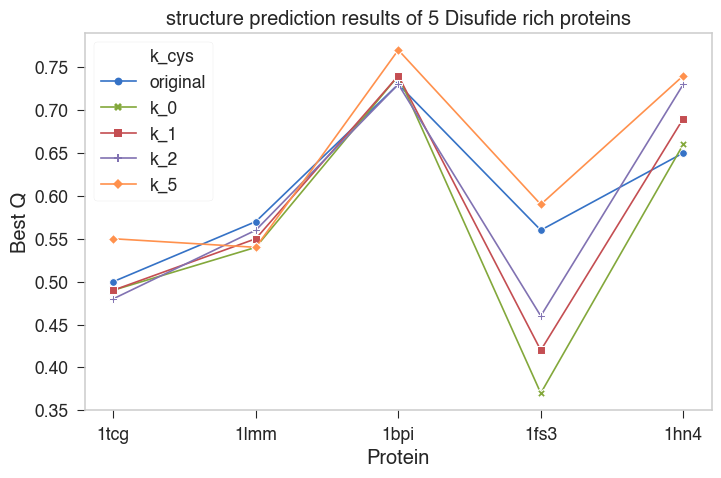

In [80]:
memory = 'ho'
filtered_data = data.query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
# filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["k_cys", "Protein"]).tail(1).sort_values(['k_cys', "Q"])
Q_max.Protein = pd.Categorical(Q_max.Protein, a.sort_values("Length").Protein.values)
Q_max.k_cys = pd.Categorical(Q_max.k_cys,  ["original", "k_0", "k_1", "k_2", "k_5"])
# Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Protein", "Q", hue="k_cys", markers=True, data=Q_max.sort_values("Length").reset_index(drop=True), style="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"structure prediction results of 5 Disufide rich proteins")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_complete.png", dpi=300)

In [46]:
data = data_yesCys.query("Submode == 30").reset_index(drop=True)
data.Submode = data.Submode.astype(str)
submode_list = {"0":"k_0", "1":"k_1", "2":"k_2", "3":"k_5", "4":"k_10", "5":"k_20",
    "100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",
               "30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "34":"k_10", "35":"k_20","36":"k_50",
               "130":"k_0", "131":"k_1", "132":"k_2", "133":"k_5", "134":"k_10", "135":"k_20","136":"k_50"}
submode_mem_list = {"0":"single_mem", "1":"single_mem", "2":"single_mem", "3":"single_mem", "4":"single_mem", "5":"single_mem",
    "100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem",
                   "30":"ho", "31":"ho", "32":"ho", "33":"ho", "34":"ho", "35":"ho", "36":"ho",
                   "130":"ho", "131":"ho", "132":"ho", "133":"ho", "134":"ho", "135":"ho", "136":"ho"}
submode_er_list = {"0":"no_er", "1":"no_er", "2":"no_er", "3":"no_er", "4":"no_er", "5":"no_er",
    "30":"no_er", "31":"no_er", "32":"no_er", "33":"no_er", "34":"no_er", "35":"no_er", "36":"no_er",
                   "130":"er", "131":"er", "132":"er", "133":"er", "134":"er", "135":"er", "136":"er"}
data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])
data["hasER"] = data.Submode.apply(lambda x:submode_er_list[x])

In [49]:
data["k_cys"] = "original"

In [50]:
original = data

In [51]:
data = data_noCys
data.Submode = data.Submode.astype(str)
submode_list = {"0":"k_0", "1":"k_1", "2":"k_2", "3":"k_5", "4":"k_10", "5":"k_20",
    "100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",
               "30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "34":"k_10", "35":"k_20","36":"k_50",
               "130":"k_0", "131":"k_1", "132":"k_2", "133":"k_5", "134":"k_10", "135":"k_20","136":"k_50"}
submode_mem_list = {"0":"single_mem", "1":"single_mem", "2":"single_mem", "3":"single_mem", "4":"single_mem", "5":"single_mem",
    "100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem",
                   "30":"ho", "31":"ho", "32":"ho", "33":"ho", "34":"ho", "35":"ho", "36":"ho",
                   "130":"ho", "131":"ho", "132":"ho", "133":"ho", "134":"ho", "135":"ho", "136":"ho"}
submode_er_list = {"0":"no_er", "1":"no_er", "2":"no_er", "3":"no_er", "4":"no_er", "5":"no_er",
    "30":"no_er", "31":"no_er", "32":"no_er", "33":"no_er", "34":"no_er", "35":"no_er", "36":"no_er",
                   "130":"er", "131":"er", "132":"er", "133":"er", "134":"er", "135":"er", "136":"er"}
data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])
data["hasER"] = data.Submode.apply(lambda x:submode_er_list[x])

In [52]:
data_complete = pd.concat([data, original])

In [53]:
data_complete = data_complete.reset_index(drop=True)

In [54]:
outFile = f"/Users/weilu/Research/data/openMM/complete_{subFolder}_{today}.csv"
data_complete.reset_index(drop=True).to_csv(outFile)

In [36]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1fs3", "1bpi", "1hn4", "1lmm", "1tcg"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
# subMode_list += [0, 1, 2, 3, 4, 5]
# subMode_list += [30, 31, 32, 33, 34, 35]
subMode_list += [30, 31, 32, 33]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "5_pdbs_yes"
subFolder = "run_without_er_gamma_yesCysCys"
pre = "/Users/weilu/Research/server/nov_2019/nov_2019/cys_1fs3/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(20):
            pre = f"/Users/weilu/Research/server/nov_2019/cys_1fs3/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)
info = pd.DataFrame(info)

/Users/weilu/Research/data/openMM/5_pdbs_yes_run_without_er_gamma_yesCysCys_12-02.csv


In [81]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/5_pdbs_yes_run_without_er_gamma_yesCysCys_12-02.csv", index_col=0)
# data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_run_without_er_gamma_noCysCys_2_11-29.csv", index_col=0)
data.Submode = data.Submode.astype(str)
submode_list = {"0":"k_0", "1":"k_1", "2":"k_2", "3":"k_5", "4":"k_10", "5":"k_20",
    "100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",
               "30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "34":"k_10", "35":"k_20","36":"k_50",
               "130":"k_0", "131":"k_1", "132":"k_2", "133":"k_5", "134":"k_10", "135":"k_20","136":"k_50"}
submode_mem_list = {"0":"single_mem", "1":"single_mem", "2":"single_mem", "3":"single_mem", "4":"single_mem", "5":"single_mem",
    "100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem",
                   "30":"ho", "31":"ho", "32":"ho", "33":"ho", "34":"ho", "35":"ho", "36":"ho",
                   "130":"ho", "131":"ho", "132":"ho", "133":"ho", "134":"ho", "135":"ho", "136":"ho"}
submode_er_list = {"0":"no_er", "1":"no_er", "2":"no_er", "3":"no_er", "4":"no_er", "5":"no_er",
    "30":"no_er", "31":"no_er", "32":"no_er", "33":"no_er", "34":"no_er", "35":"no_er", "36":"no_er",
                   "130":"er", "131":"er", "132":"er", "133":"er", "134":"er", "135":"er", "136":"er"}
data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])
data["hasER"] = data.Submode.apply(lambda x:submode_er_list[x])

In [82]:
a = pd.read_csv("/Users/weilu/Research/data/openMM/length_info_12-01.csv", index_col=0)
data = data.merge(a, on="Protein")

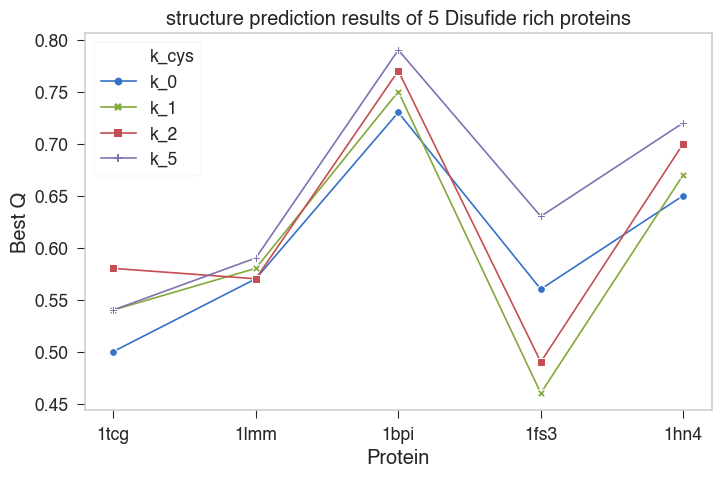

In [83]:

memory = 'ho'
filtered_data = data.query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
# filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Protein"]).tail(1).sort_values(['Submode', "Q"])
Q_max.Protein = pd.Categorical(Q_max.Protein, a.sort_values("Length").Protein.values)
Q_max.k_cys = pd.Categorical(Q_max.k_cys, ["k_0", "k_1", "k_2", "k_5"])
# Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Protein", "Q", hue="k_cys", markers=True, data=Q_max.sort_values("Length").reset_index(drop=True), style="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"structure prediction results of 5 Disufide rich proteins")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_original_gamma.png", dpi=300)

In [104]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1fs3", "1bpi", "1hn4", "1lmm", "1tcg"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
subMode_list += [0, 1, 2, 3, 4, 5]
subMode_list += [30, 31, 32, 33, 34, 35]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "5_pdbs"
subFolder = "run_without_er_gamma_noCysCys_2"
pre = "/Users/weilu/Research/server/nov_2019/nov_2019/cys_1fs3/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(20):
            pre = f"/Users/weilu/Research/server/nov_2019/cys_1fs3/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)
info = pd.DataFrame(info)

/Users/weilu/Research/data/openMM/5_pdbs_run_without_er_gamma_noCysCys_2_12-01.csv


In [75]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/5_pdbs_run_without_er_gamma_noCysCys_2_12-01.csv", index_col=0)
# data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_run_without_er_gamma_noCysCys_2_11-29.csv", index_col=0)
data.Submode = data.Submode.astype(str)
submode_list = {"0":"k_0", "1":"k_1", "2":"k_2", "3":"k_5", "4":"k_10", "5":"k_20",
    "100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",
               "30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "34":"k_10", "35":"k_20","36":"k_50",
               "130":"k_0", "131":"k_1", "132":"k_2", "133":"k_5", "134":"k_10", "135":"k_20","136":"k_50"}
submode_mem_list = {"0":"single_mem", "1":"single_mem", "2":"single_mem", "3":"single_mem", "4":"single_mem", "5":"single_mem",
    "100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem",
                   "30":"ho", "31":"ho", "32":"ho", "33":"ho", "34":"ho", "35":"ho", "36":"ho",
                   "130":"ho", "131":"ho", "132":"ho", "133":"ho", "134":"ho", "135":"ho", "136":"ho"}
submode_er_list = {"0":"no_er", "1":"no_er", "2":"no_er", "3":"no_er", "4":"no_er", "5":"no_er",
    "30":"no_er", "31":"no_er", "32":"no_er", "33":"no_er", "34":"no_er", "35":"no_er", "36":"no_er",
                   "130":"er", "131":"er", "132":"er", "133":"er", "134":"er", "135":"er", "136":"er"}
data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])
data["hasER"] = data.Submode.apply(lambda x:submode_er_list[x])

/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [76]:
# a = []
# for pdb in pdb_list:
#     seq = getSeqFromFasta(f"/Users/weilu/Research/server/nov_2019/cys_1fs3/setups/{pdb}/{pdb}.fasta")
#     a.append([pdb, len(seq)])
# a.to_csv("/Users/weilu/Research/data/openMM/length_info_12-01.csv")
a = pd.read_csv("/Users/weilu/Research/data/openMM/length_info_12-01.csv", index_col=0)
data = data.merge(a, on="Protein")

In [30]:
x = np.array([1,123,1])

In [77]:
plt.rcParams['figure.figsize'] = 0.5 * np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

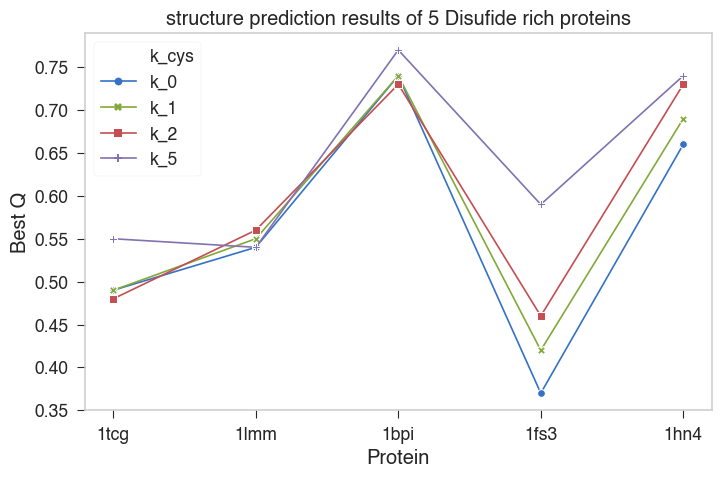

In [78]:
memory = 'ho'
filtered_data = data.query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
# filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Protein"]).tail(1).sort_values(['Submode', "Q"])
Q_max.Protein = pd.Categorical(Q_max.Protein, a.sort_values("Length").Protein.values)
Q_max.k_cys = pd.Categorical(Q_max.k_cys, ["k_0", "k_1", "k_2", "k_5"])
# Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Protein", "Q", hue="k_cys", markers=True, data=Q_max.sort_values("Length").reset_index(drop=True), style="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"structure prediction results of 5 Disufide rich proteins")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys.png", dpi=300)

Text(0.5, 1.0, 'ho')

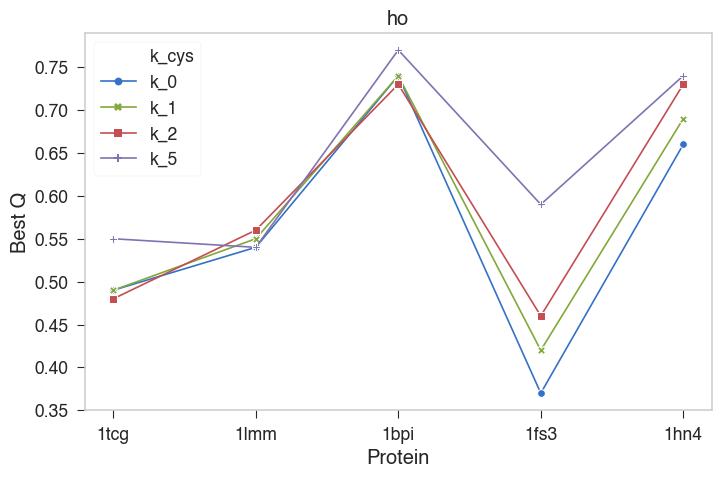

In [28]:
memory = 'ho'
filtered_data = data.query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
# filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Protein"]).tail(1).sort_values(['Submode', "Q"])
Q_max.Protein = pd.Categorical(Q_max.Protein, a.sort_values("Length").Protein.values)
Q_max.k_cys = pd.Categorical(Q_max.k_cys, ["k_0", "k_1", "k_2", "k_5"])
# Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Protein", "Q", hue="k_cys", markers=True, data=Q_max.sort_values("Length").reset_index(drop=True), style="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"{memory}")

Text(0.5, 1.0, '1hn4 ho')

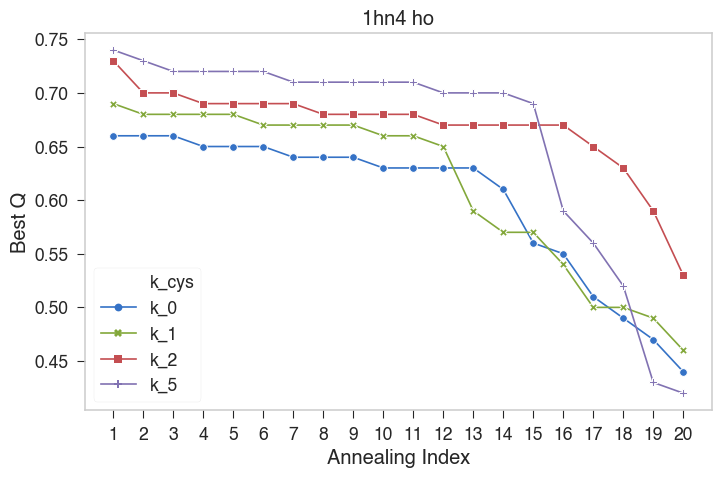

In [106]:
protein = '1hn4'
memory = 'ho'
filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="k_cys", markers=True, data=Q_max, style="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"{protein} {memory}")

Text(0.5, 1.0, '1lmm ho')

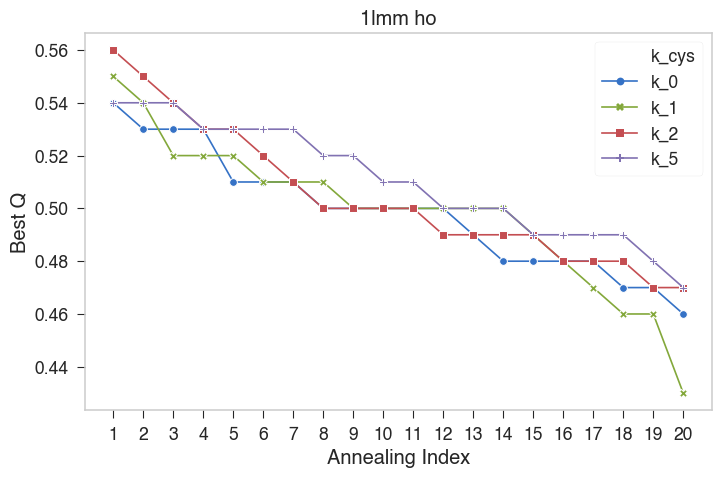

In [107]:
protein = '1lmm'
memory = 'ho'
filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="k_cys", markers=True, data=Q_max, style="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"{protein} {memory}")

Text(0.5, 1.0, '1tcg ho')

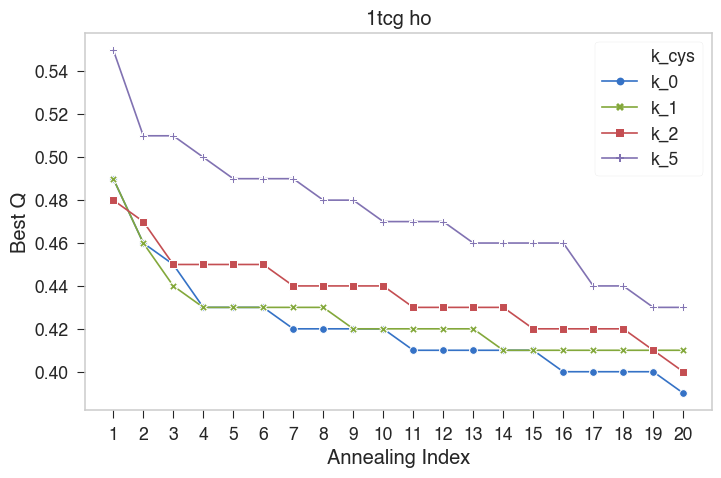

In [108]:

protein = '1tcg'
memory = 'ho'
filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="k_cys", markers=True, data=Q_max, style="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"{protein} {memory}")

In [87]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1fs3", "1bpi"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
subMode_list += [0, 1, 2, 3, 4, 5]
subMode_list += [30, 31, 32, 33, 34, 35]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "1fs3_1bpi"
subFolder = "run_without_er_gamma_noCysCys_2"
pre = "/Users/weilu/Research/server/nov_2019/nov_2019/cys_1fs3/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(20):
            pre = f"/Users/weilu/Research/server/nov_2019/cys_1fs3/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)
info = pd.DataFrame(info)

/Users/weilu/Research/data/openMM/1fs3_1bpi_run_without_er_gamma_noCysCys_2_11-29.csv


In [88]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_1bpi_run_without_er_gamma_noCysCys_2_11-29.csv", index_col=0)
# data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_run_without_er_gamma_noCysCys_2_11-29.csv", index_col=0)
data.Submode = data.Submode.astype(str)
submode_list = {"0":"k_0", "1":"k_1", "2":"k_2", "3":"k_5", "4":"k_10", "5":"k_20",
    "100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",
               "30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "34":"k_10", "35":"k_20","36":"k_50",
               "130":"k_0", "131":"k_1", "132":"k_2", "133":"k_5", "134":"k_10", "135":"k_20","136":"k_50"}
submode_mem_list = {"0":"single_mem", "1":"single_mem", "2":"single_mem", "3":"single_mem", "4":"single_mem", "5":"single_mem",
    "100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem",
                   "30":"ho", "31":"ho", "32":"ho", "33":"ho", "34":"ho", "35":"ho", "36":"ho",
                   "130":"ho", "131":"ho", "132":"ho", "133":"ho", "134":"ho", "135":"ho", "136":"ho"}
submode_er_list = {"0":"no_er", "1":"no_er", "2":"no_er", "3":"no_er", "4":"no_er", "5":"no_er",
    "30":"no_er", "31":"no_er", "32":"no_er", "33":"no_er", "34":"no_er", "35":"no_er", "36":"no_er",
                   "130":"er", "131":"er", "132":"er", "133":"er", "134":"er", "135":"er", "136":"er"}
data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])
data["hasER"] = data.Submode.apply(lambda x:submode_er_list[x])

Text(0.5, 1.0, '1fs3 ho')

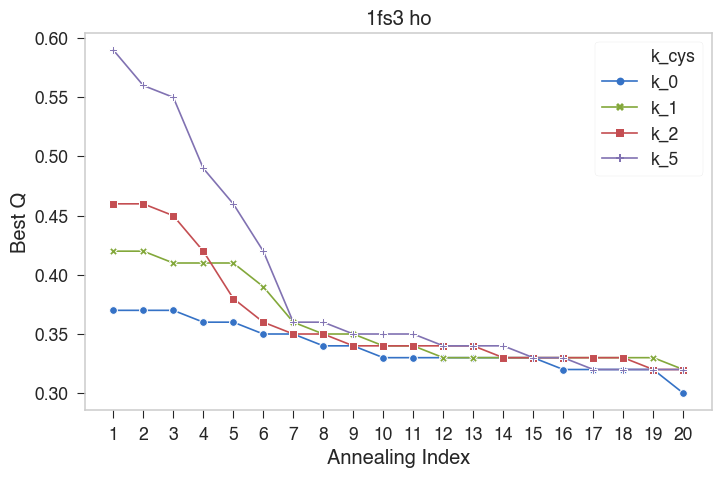

In [95]:
protein = '1fs3'
memory = 'ho'
filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="k_cys", markers=True, data=Q_max, style="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"{protein} {memory}")

Text(0.5, 1.0, '1bpi ho')

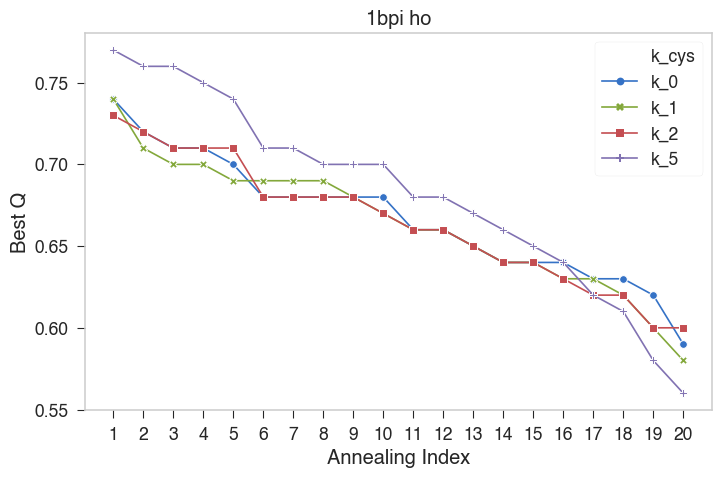

In [94]:
protein = '1bpi'
memory = 'ho'
filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="k_cys", markers=True, data=Q_max, style="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"{protein} {memory}")

Text(0.5, 1.0, '1fs3 single memroy')

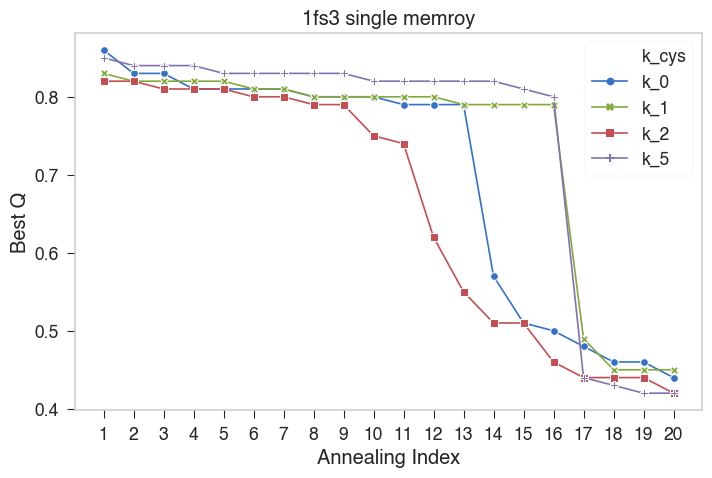

In [89]:
protein = '1fs3'
filtered_data = data.query(f"Protein == '{protein}'").query("memory == 'single_mem'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="k_cys", markers=True, data=Q_max, style="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"{protein} single memroy")

Text(0.5, 1.0, '1bpi single memroy')

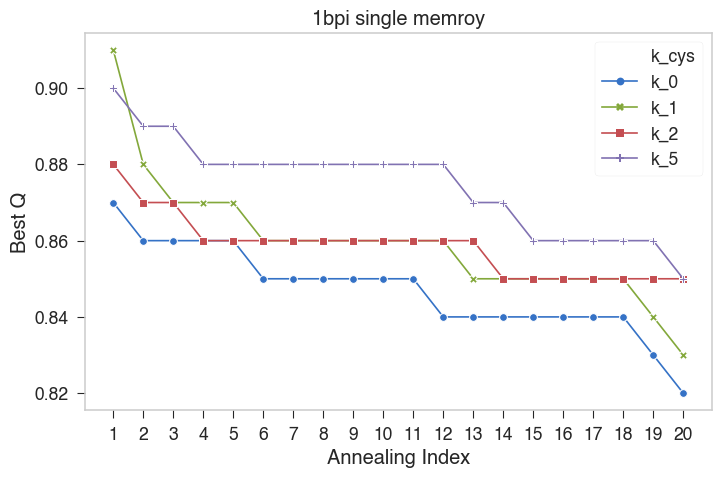

In [90]:
protein = '1bpi'
filtered_data = data.query(f"Protein == '{protein}'").query("memory == 'single_mem'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="k_cys", markers=True, data=Q_max, style="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"{protein} single memroy")

Text(0.5, 1.0, 'single memroy')

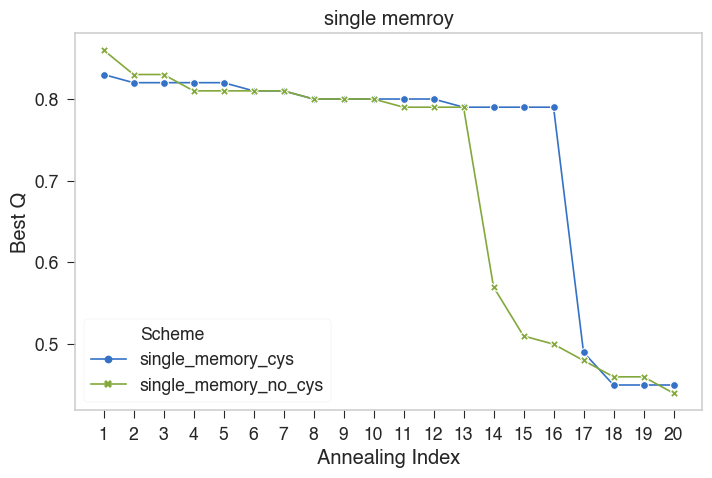

In [101]:
protein = '1bpi'
filtered_data = data.query("Protein == '1fs3'").query("memory == 'single_mem'").query("k_cys == 'k_1' or k_cys == 'k_0'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

convert_dic = {"k_0":"single_memory_no_cys", "k_1":"single_memory_cys"}
Q_max["Scheme"] = Q_max["k_cys"].apply(lambda x: convert_dic[x])
Q_max = Q_max.sort_values("Scheme")
# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="Scheme", markers=True, data=Q_max, style="Scheme", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title("single memroy")

Text(0.5, 1.0, 'ho')

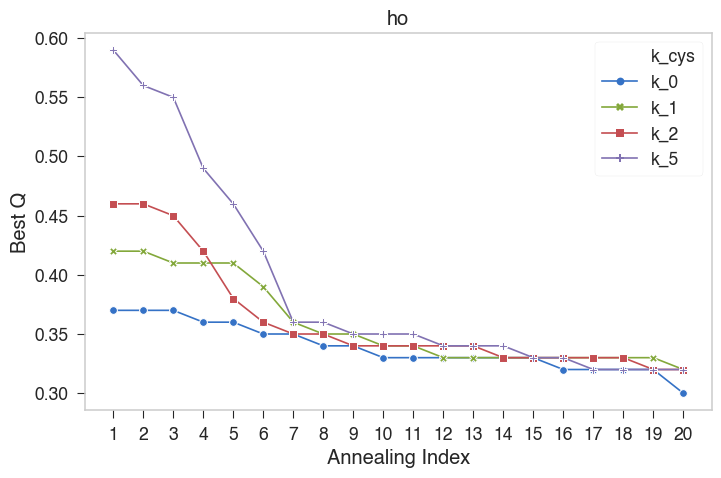

In [80]:
# filtered_data = data.query("memory == 'ho'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Annealing Index", "Q", hue="k_cys", markers=True, data=Q_max, style="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, 21, 1))
plt.title("ho")

In [58]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1fs3"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
subMode_list += [30, 31, 32, 33, 34, 35]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "1fs3"
subFolder = "run_without_er_gamma_noCysCys"
pre = "/Users/weilu/Research/server/nov_2019/nov_2019/cys_1fs3/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(10):
            pre = f"/Users/weilu/Research/server/nov_2019/cys_1fs3/{subFolder}/1fs3/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)
info = pd.DataFrame(info)

/Users/weilu/Research/data/openMM/1fs3_run_without_er_gamma_noCysCys_11-26.csv


In [59]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_run_without_er_gamma_noCysCys_11-26.csv", index_col=0)
data.Submode = data.Submode.astype(str)
submode_list = {"100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",
               "30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "34":"k_10", "35":"k_20","36":"k_50",
               "130":"k_0", "131":"k_1", "132":"k_2", "133":"k_5", "134":"k_10", "135":"k_20","136":"k_50"}
submode_mem_list = {"100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem",
                   "30":"ho", "31":"ho", "32":"ho", "33":"ho", "34":"ho", "35":"ho", "36":"ho",
                   "130":"ho", "131":"ho", "132":"ho", "133":"ho", "134":"ho", "135":"ho", "136":"ho"}
submode_er_list = {"30":"no_er", "31":"no_er", "32":"no_er", "33":"no_er", "34":"no_er", "35":"no_er", "36":"no_er",
                   "130":"er", "131":"er", "132":"er", "133":"er", "134":"er", "135":"er", "136":"er"}
data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])
data["hasER"] = data.Submode.apply(lambda x:submode_er_list[x])

Text(0, 0.5, 'Best Q')

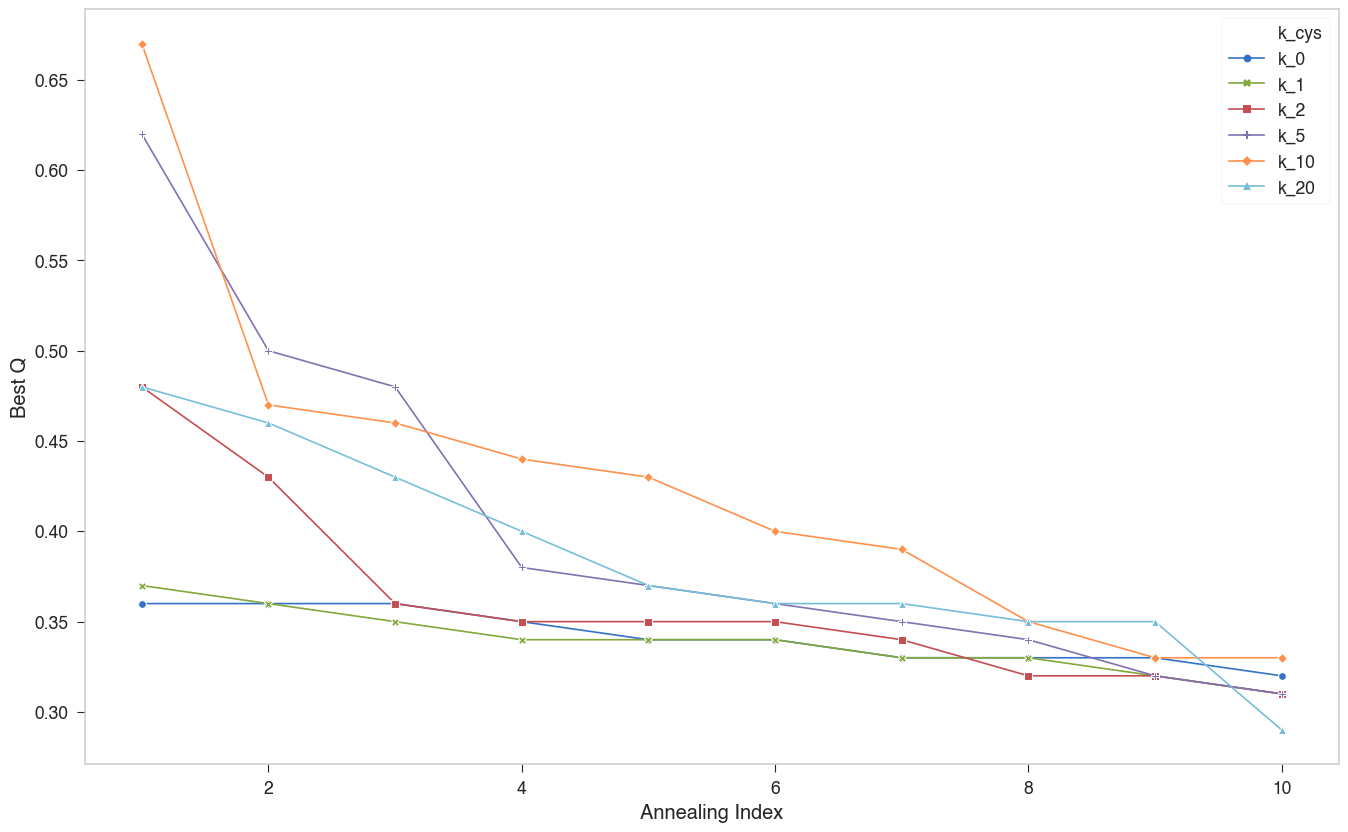

In [62]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, n_run+1, 1))

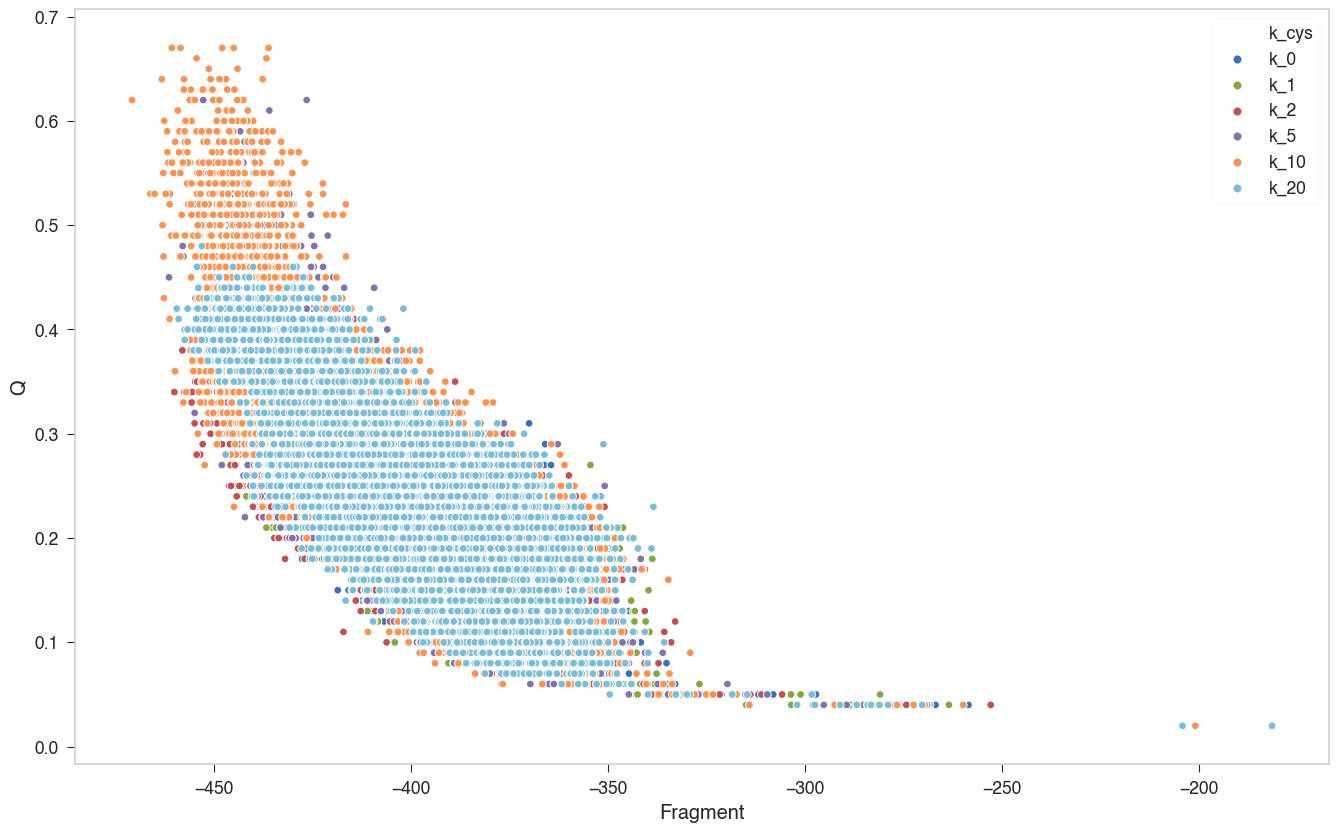

In [61]:
sns.scatterplot("Fragment", "Q", data=data, hue="k_cys")

In [25]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1fs3"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
subMode_list += [30, 31, 32, 33, 34, 35]
subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "1fs3"
subFolder = "run_with_ho_with_and_without_er"
pre = "/Users/weilu/Research/server/nov_2019/nov_2019/cys_1fs3/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(10):
            pre = f"/Users/weilu/Research/server/nov_2019/cys_1fs3/{subFolder}/1fs3/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)
info = pd.DataFrame(info)

/Users/weilu/Research/data/openMM/1fs3_run_with_ho_with_and_without_er_11-26.csv


In [28]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_run_with_ho_with_and_without_er_11-26.csv", index_col=0)
data.Submode = data.Submode.astype(str)
submode_list = {"100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",
               "30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "34":"k_10", "35":"k_20","36":"k_50",
               "130":"k_0", "131":"k_1", "132":"k_2", "133":"k_5", "134":"k_10", "135":"k_20","136":"k_50"}
submode_mem_list = {"100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem",
                   "30":"ho", "31":"ho", "32":"ho", "33":"ho", "34":"ho", "35":"ho", "36":"ho",
                   "130":"ho", "131":"ho", "132":"ho", "133":"ho", "134":"ho", "135":"ho", "136":"ho"}
submode_er_list = {"30":"no_er", "31":"no_er", "32":"no_er", "33":"no_er", "34":"no_er", "35":"no_er", "36":"no_er",
                   "130":"er", "131":"er", "132":"er", "133":"er", "134":"er", "135":"er", "136":"er"}
data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])
data["hasER"] = data.Submode.apply(lambda x:submode_er_list[x])

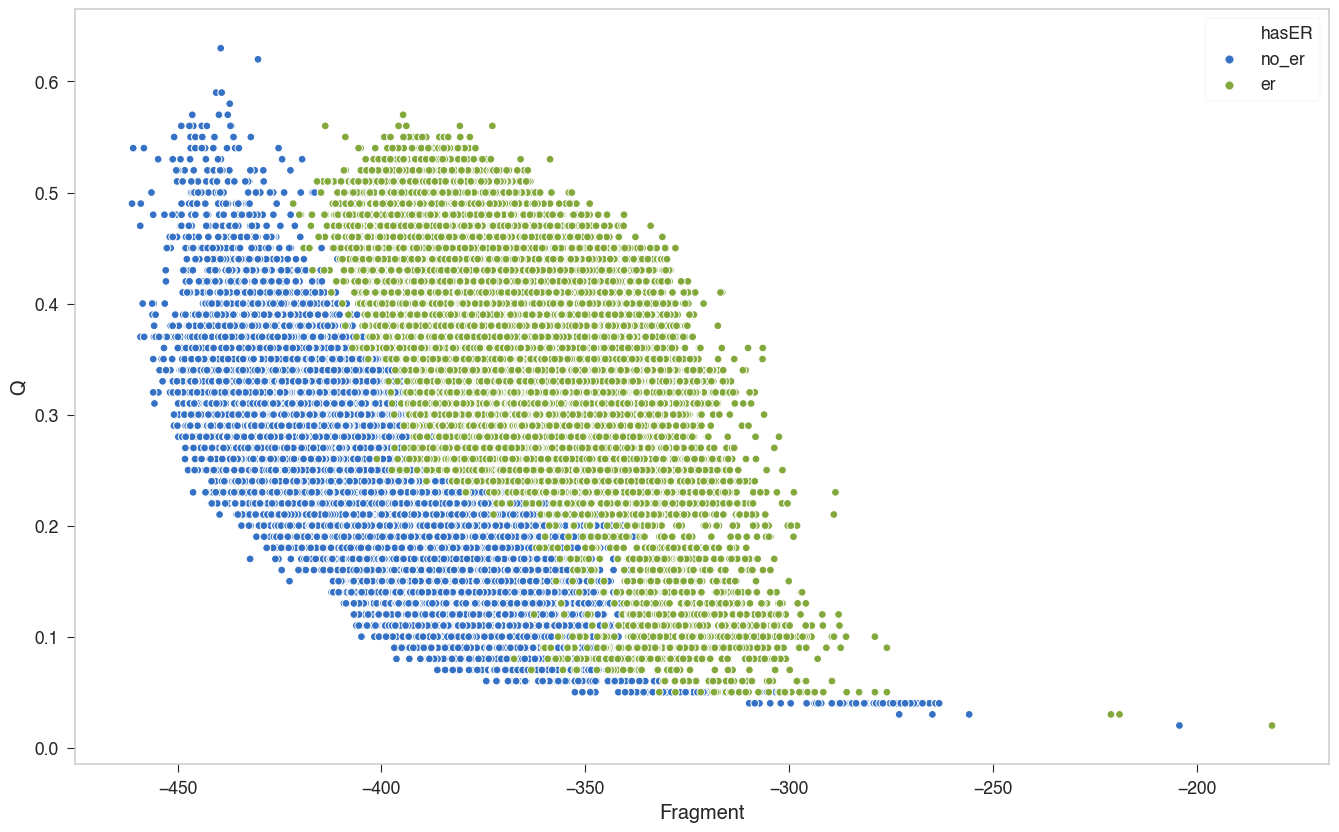

In [57]:
sns.scatterplot("Fragment", "Q", data=data, hue="hasER")

In [33]:
len(Q_max)

120

Text(0, 0.5, 'Best Q')

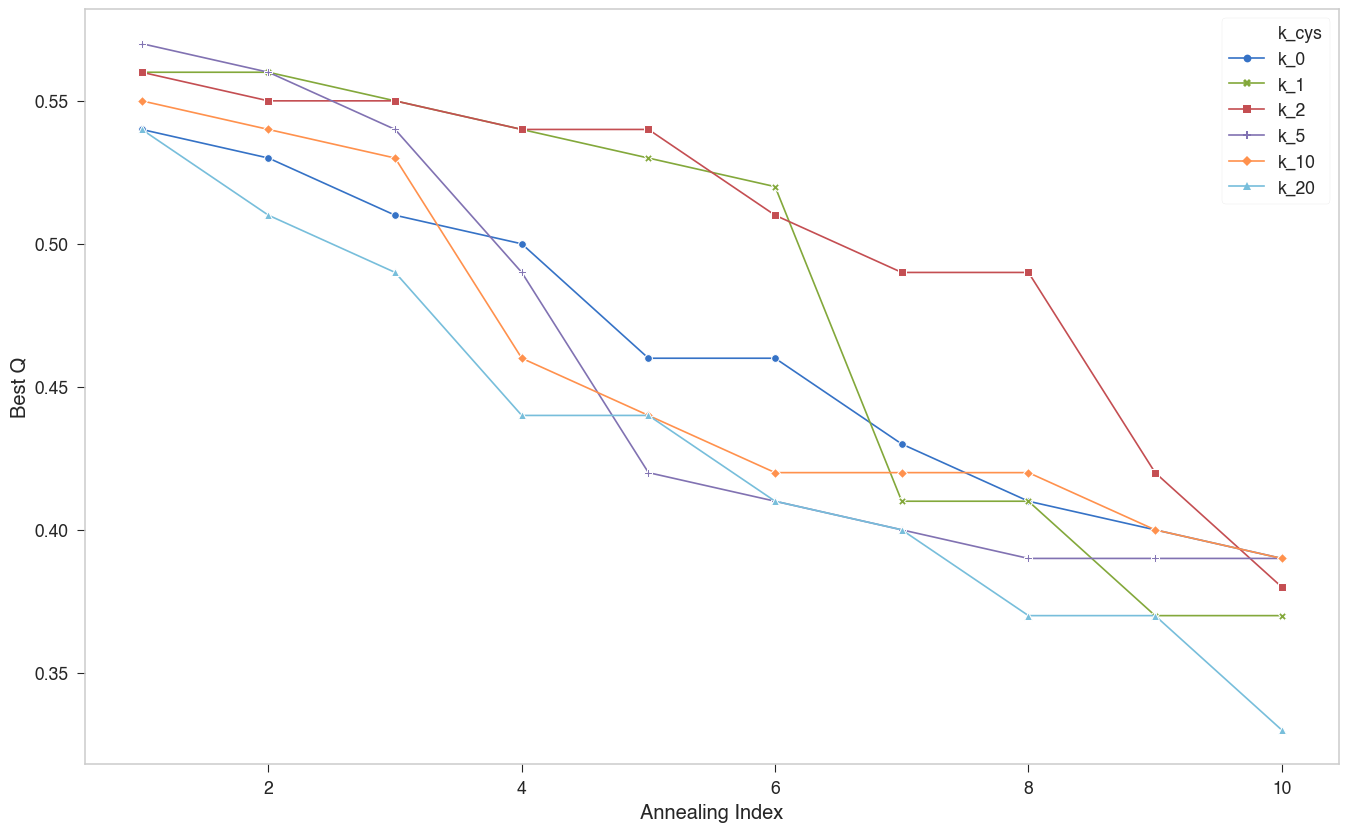

In [52]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max.query("hasER=='er'"), hue="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, n_run+1, 1))

Text(0, 0.5, 'Best Q')

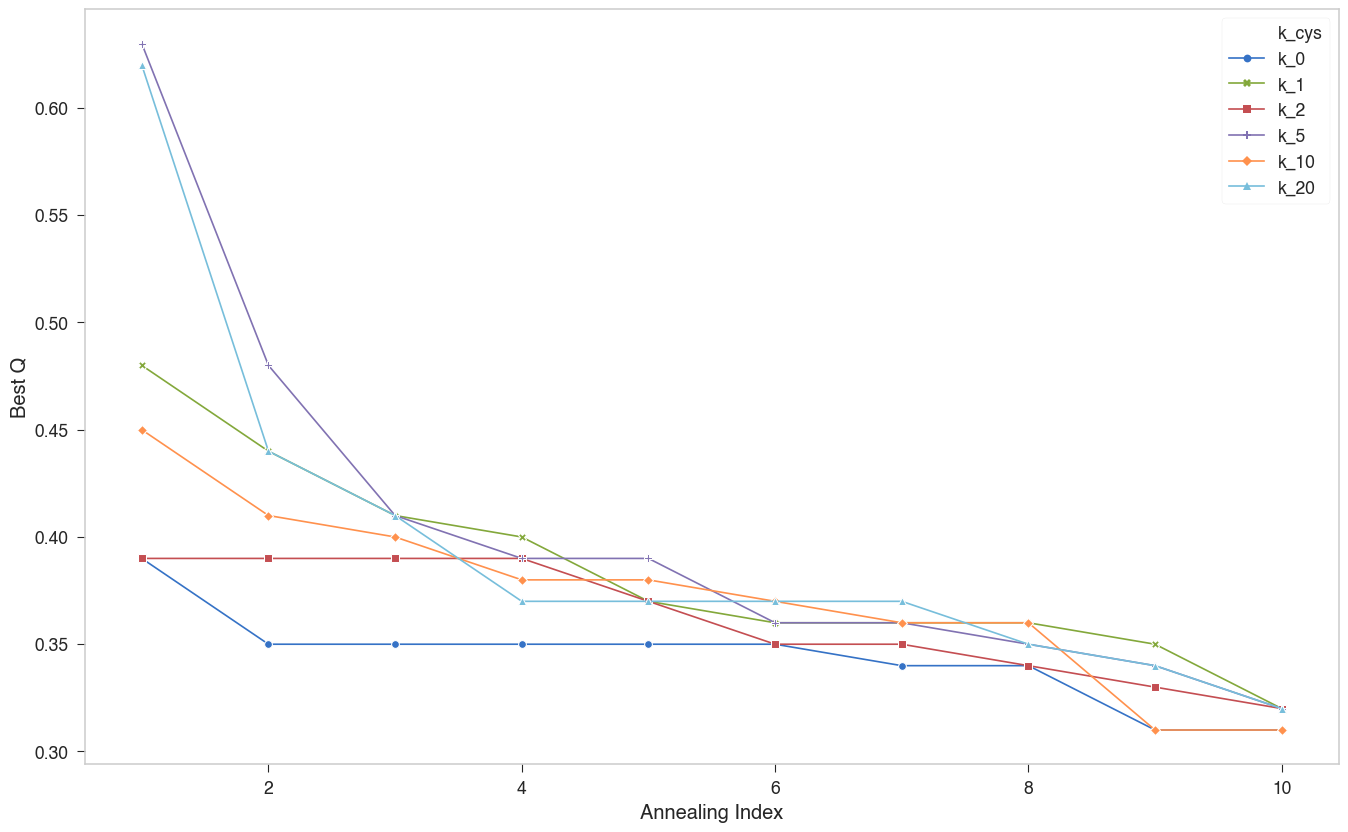

In [51]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max.query("hasER=='no_er'"), hue="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, n_run+1, 1))

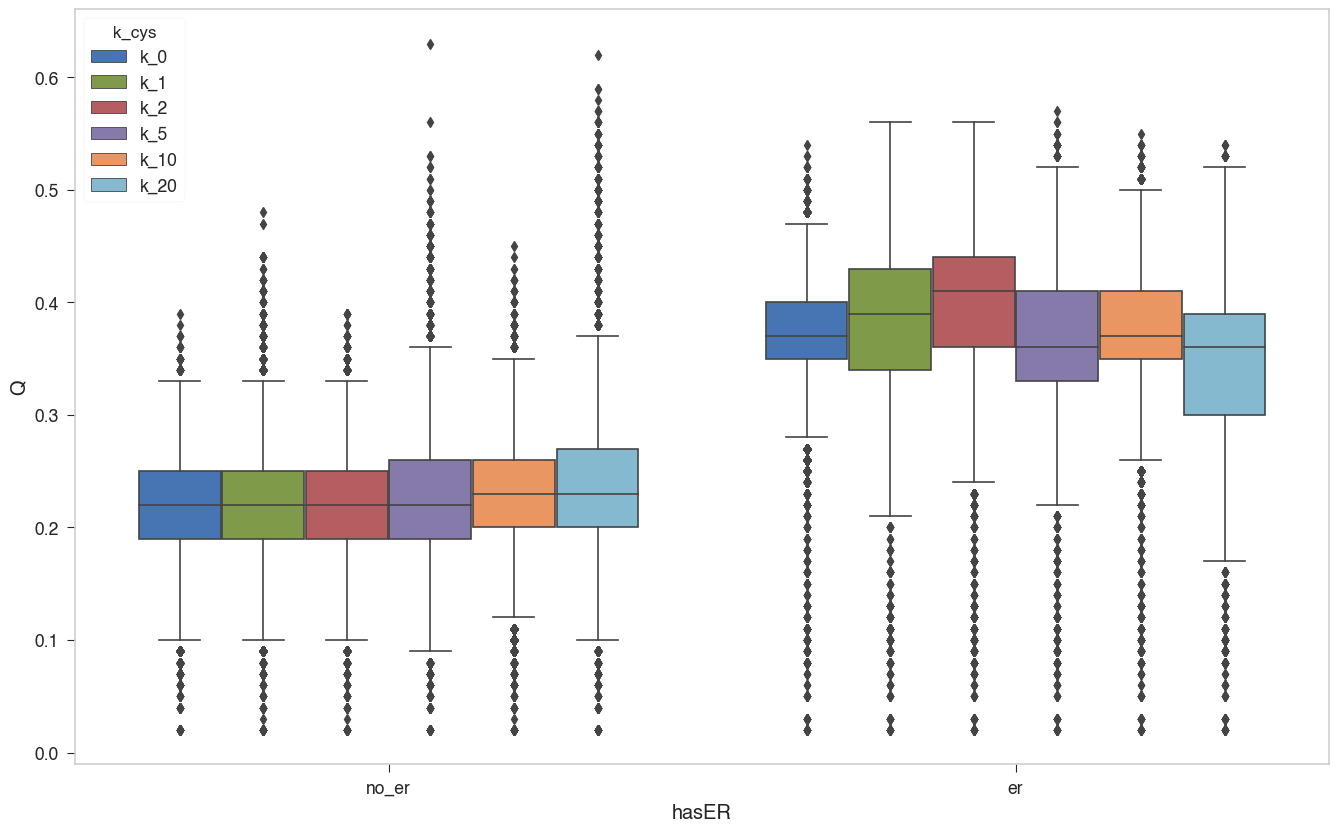

In [49]:
sns.boxplot("hasER", "Q", hue="k_cys", data=data)

In [3]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1fs3"]
subMode_list = []
subMode_list += [100, 101, 102, 103, 104, 105, 106]
subMode_list += [110, 111, 112, 113, 114, 115, 116]
subMode_list += [120, 121, 122, 123, 124, 125, 126]
simulationType = "1fs3"
subFolder = "run_with_er_and_gamma_noCysCys"
pre = "/Users/weilu/Research/server/nov_2019/nov_2019/cys_1fs3/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(5):
            pre = f"/Users/weilu/Research/server/nov_2019/cys_1fs3/{subFolder}/1fs3/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)
info = pd.DataFrame(info)

/Users/weilu/Research/data/openMM/1fs3_run_with_er_and_gamma_noCysCys_11-25.csv


In [5]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_run_with_er_and_gamma_noCysCys_11-25.csv", index_col=0)
data.Submode = data.Submode.astype(str)
submode_list = {"100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",}
submode_mem_list = {"100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem"}

data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])

In [ ]:
sns.boxplot("memory", "Q", hue="k_cys", data=data)

In [11]:
data.head()

Steps     Q      Rg  Backbone    Rama  Contact  Fragment  Membrane  \
0      0  0.02  117.03    235.25 -482.07   -68.50   -108.20       0.0   
1      1  0.03  112.18      7.97 -506.18  -106.41   -154.50       0.0   
2      2  0.05   93.02    714.48 -448.93   -99.51   -251.34       0.0   
3      3  0.08   76.39    696.20 -530.75  -101.25   -307.30       0.0   
4      4  0.08   66.41    756.78 -527.91  -102.74   -311.95       0.0   

        ER  TBM_Q  Beta  Pap  Helical  Disulfide    Total  Run Protein  \
0  -570.51    0.0  0.00  0.0      0.0        0.0  -994.04    0    1fs3   
1  -662.92    0.0 -0.00  0.0      0.0        0.0 -1422.04    0    1fs3   
2  -863.40    0.0 -2.08  0.0      0.0        0.0  -950.78    0    1fs3   
3 -1097.60    0.0 -7.80  0.0      0.0        0.0 -1348.49    0    1fs3   
4 -1235.44    0.0 -9.06  0.0      0.0        0.0 -1430.33    0    1fs3   

  Submode k_cys      memory  
0     100   k_0  single_mem  
1     100   k_0  single_mem  
2     100   k_0  single_mem  
3     100   k_0  single_mem  
4     100   k_0  single_mem

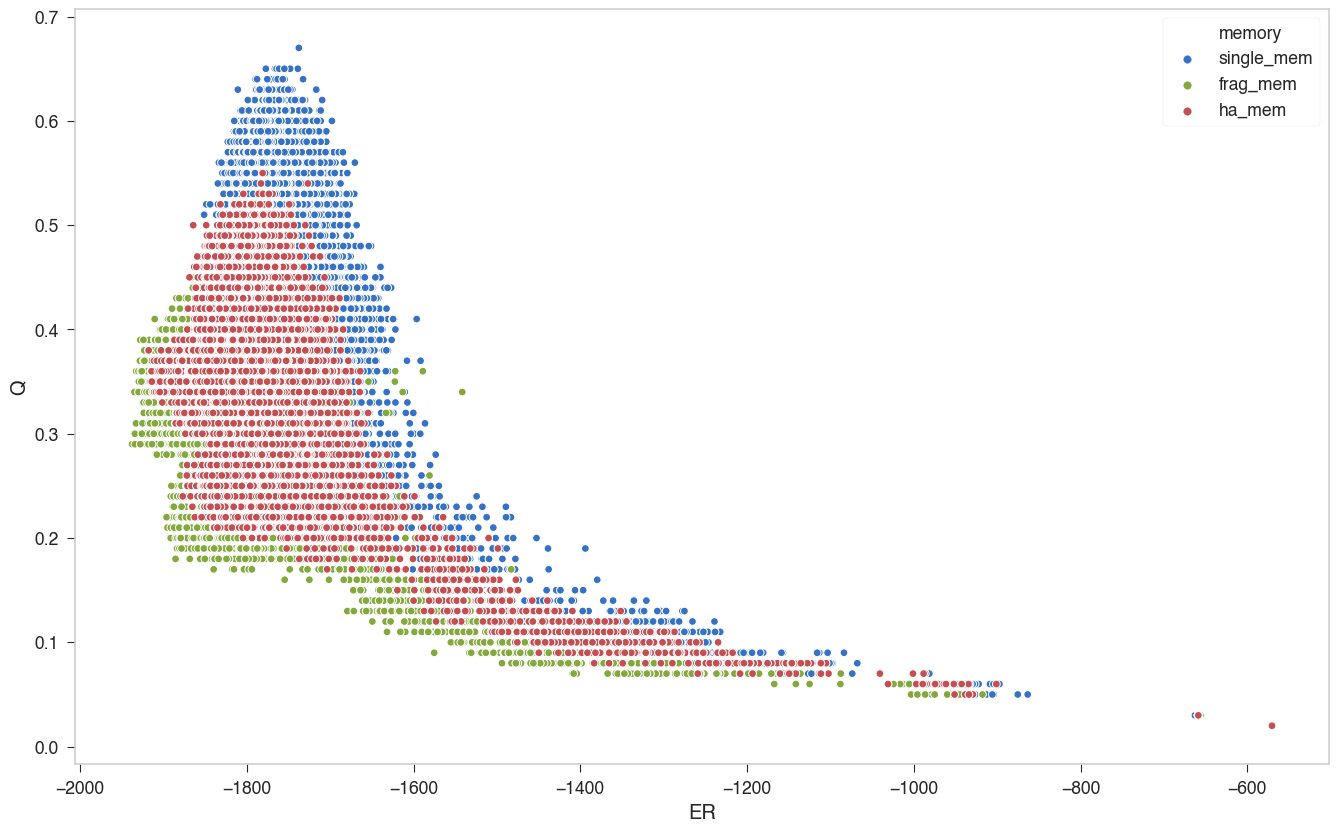

In [12]:
sns.scatterplot("ER", "Q", data=data, hue="memory")

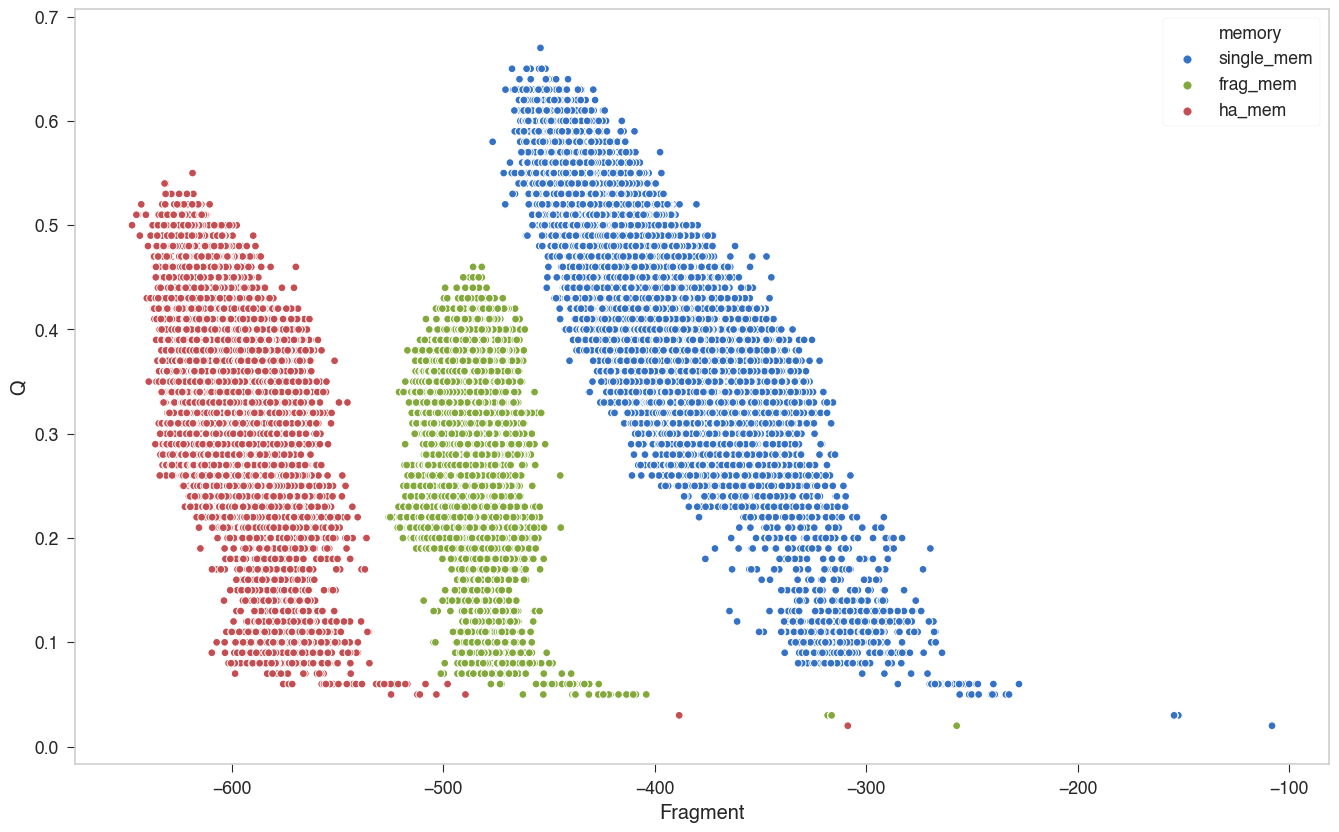

In [10]:
sns.scatterplot("Fragment", "Q", data=data, hue="memory")

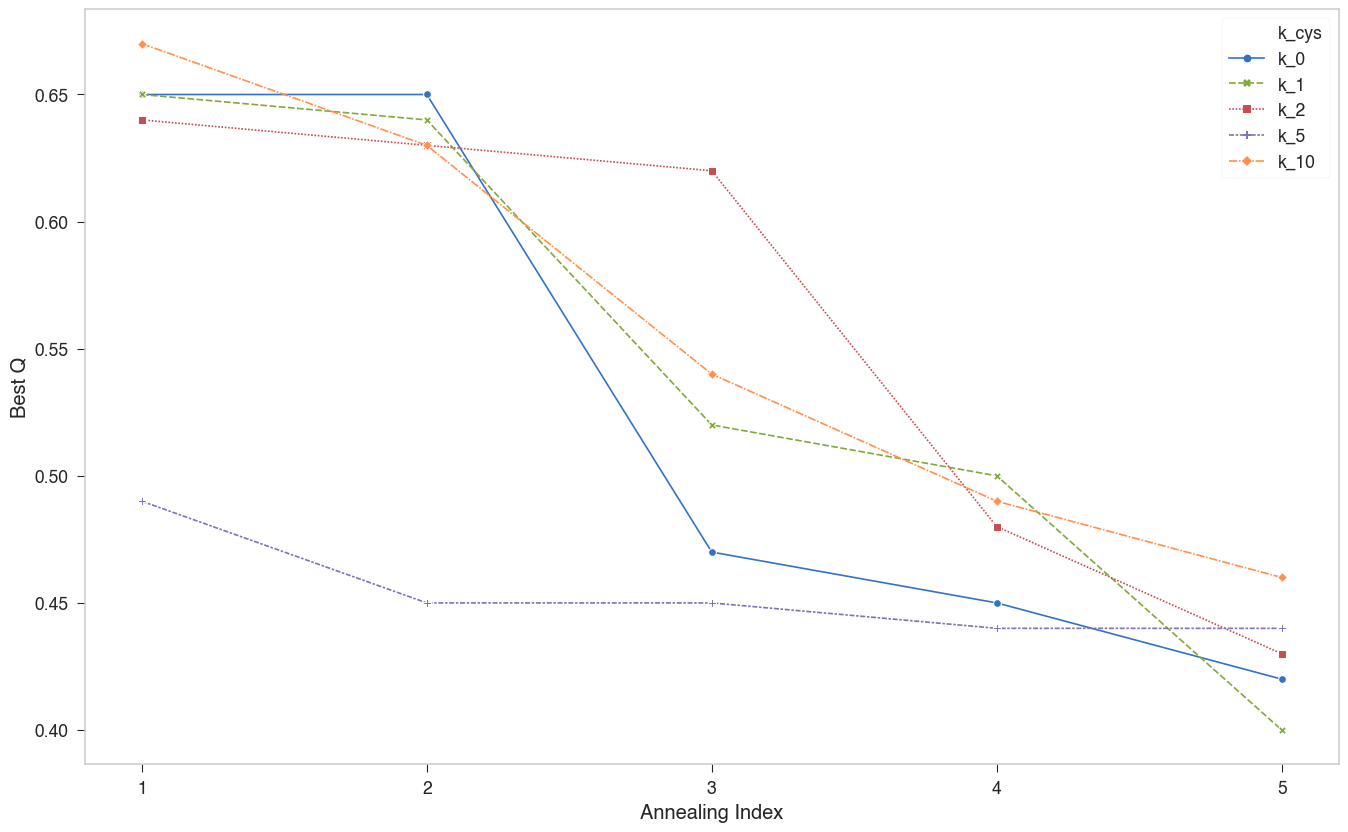

In [9]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
# Q_max["Annealing Index"] = list(range(20, 0, -1))*4
n_run = 5
Q_max["Annealing Index"] = list(range(n_run, 0, -1))*len(subMode_list)

# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max.query("memory == 'single_mem'").query("k_cys != 'k_50' and k_cys != 'k_20'"), hue="k_cys")
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, n_run+1, 1))

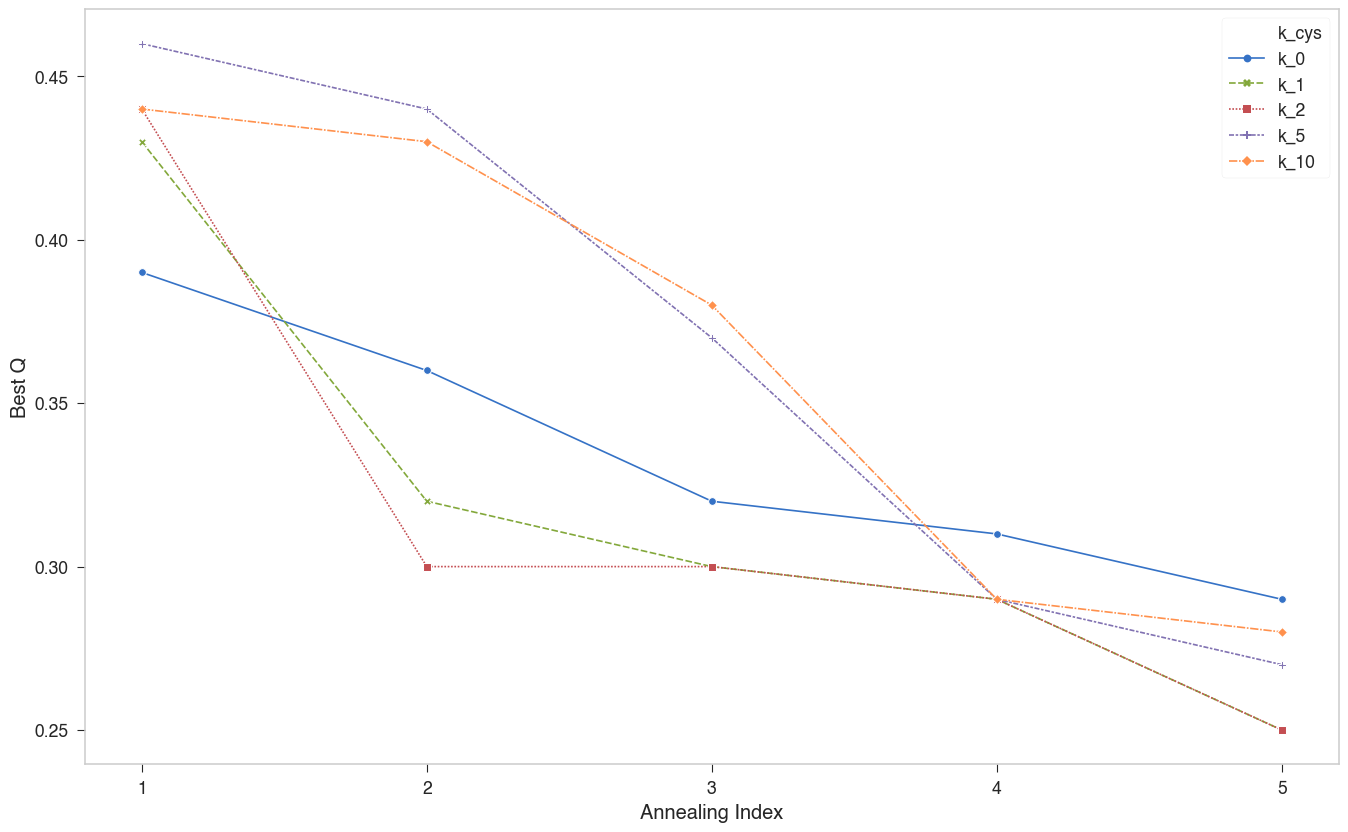

In [8]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
# Q_max["Annealing Index"] = list(range(20, 0, -1))*4
n_run = 5
Q_max["Annealing Index"] = list(range(n_run, 0, -1))*len(subMode_list)

# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max.query("memory == 'frag_mem'").query("k_cys != 'k_50' and k_cys != 'k_20'"), hue="k_cys")
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, n_run+1, 1))

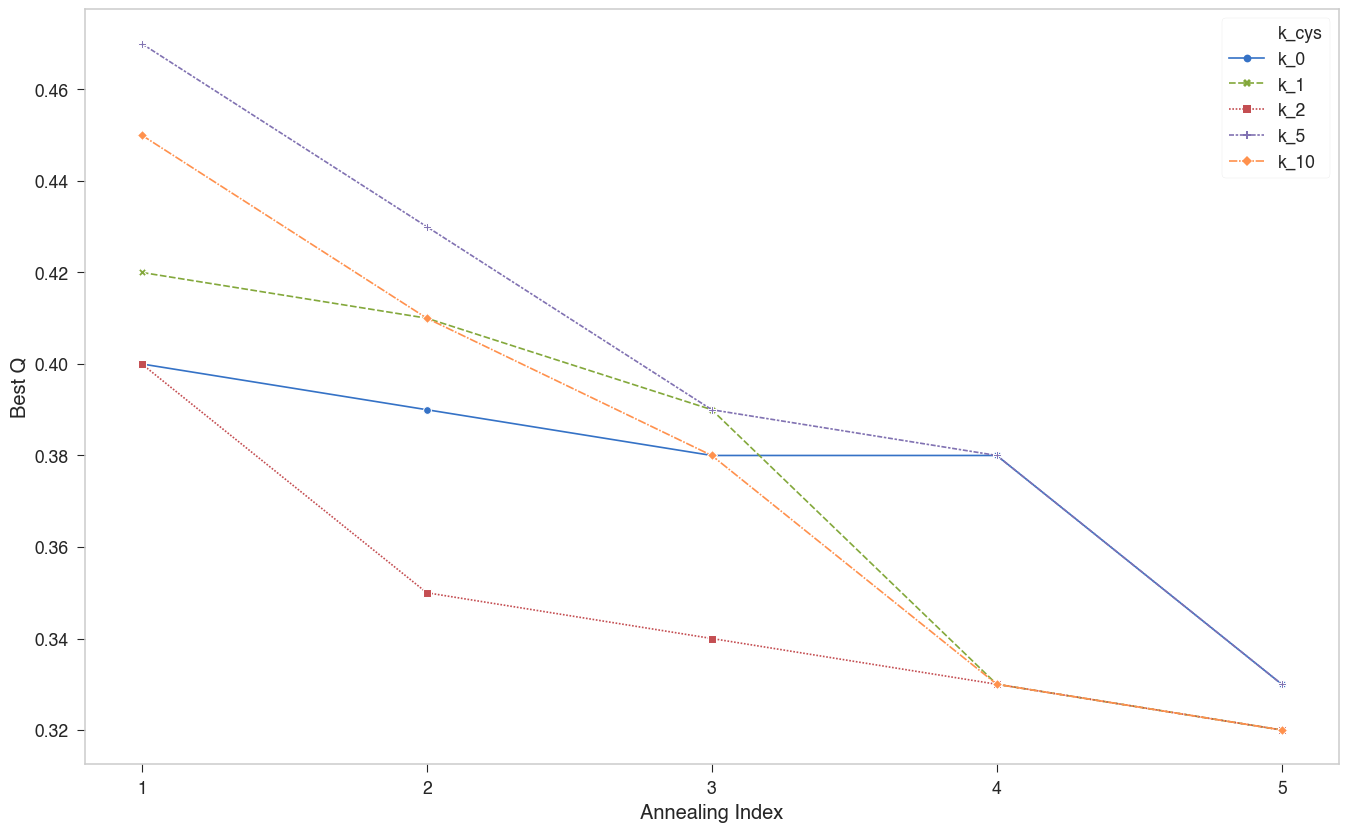

In [7]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
# Q_max["Annealing Index"] = list(range(20, 0, -1))*4
n_run = 5
Q_max["Annealing Index"] = list(range(n_run, 0, -1))*len(subMode_list)

# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max.query("memory == 'ha_mem'").query("k_cys != 'k_50' and k_cys != 'k_20'"), hue="k_cys")
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, n_run+1, 1))

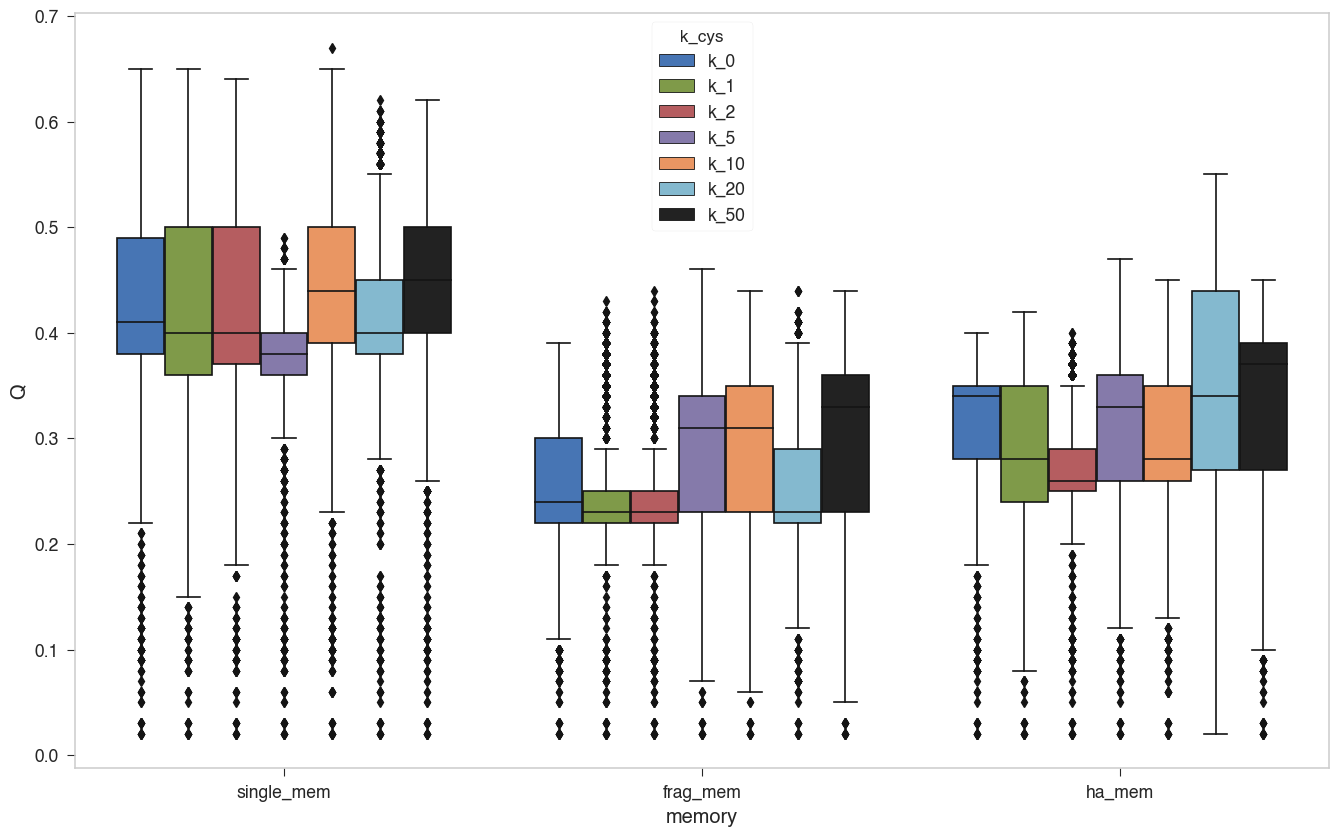

In [6]:
sns.boxplot("memory", "Q", hue="k_cys", data=data)

In [6]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1fs3"]
subMode_list = []
subMode_list += [100, 101, 102, 103, 104, 105, 106]
subMode_list += [110, 111, 112, 113, 114, 115, 116]
subMode_list += [120, 121, 122, 123, 124, 125, 126]
simulationType = "1fs3"
subFolder = "run_with_er"
pre = "/Users/weilu/Research/server/nov_2019/nov_2019/cys_1fs3/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(5):
            pre = f"/Users/weilu/Research/server/nov_2019/cys_1fs3/{subFolder}/1fs3/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)
info = pd.DataFrame(info)

/Users/weilu/Research/data/openMM/1fs3_run_with_er_11-22.csv


In [7]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_run_with_er_11-22.csv", index_col=0)
data.Submode = data.Submode.astype(str)

In [9]:
submode_list = {"100":"k_0", "101":"k_1", "102":"k_2", "103":"k_5", "104":"k_10", "105":"k_20", "106":"k_50",
               "110":"k_0", "111":"k_1", "112":"k_2", "113":"k_5", "114":"k_10", "115":"k_20", "116":"k_50",
               "120":"k_0", "121":"k_1", "122":"k_2", "123":"k_5", "124":"k_10", "125":"k_20","126":"k_50",}
submode_mem_list = {"100":"single_mem", "101":"single_mem", "102":"single_mem", "103":"single_mem", "104":"single_mem", "105":"single_mem","106":"single_mem",
               "110":"frag_mem", "111":"frag_mem", "112":"frag_mem", "113":"frag_mem", "114":"frag_mem", "115":"frag_mem","116":"frag_mem",
                   "120":"ha_mem", "121":"ha_mem", "122":"ha_mem", "123":"ha_mem", "124":"ha_mem", "125":"ha_mem", "126":"ha_mem"}

data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])

In [14]:
data.head()

Steps     Q      Rg  Backbone    Rama  Contact  Fragment  Membrane  \
0      0  0.02  117.03    235.25 -482.07   -68.50   -108.20       0.0   
1      1  0.03  112.18      7.97 -506.18  -106.41   -154.50       0.0   
2      2  0.06   90.85    750.21 -424.29   -95.11   -230.27       0.0   
3      3  0.09   74.45    708.21 -500.06  -108.43   -330.87       0.0   
4      4  0.10   65.17    662.22 -508.81  -108.11   -316.09       0.0   

        ER  TBM_Q   Beta   Pap  Helical  Disulfide    Total  Run Protein  \
0  -570.51    0.0   0.00  0.00      0.0        0.0  -994.04    0    1fs3   
1  -662.92    0.0  -0.00  0.00      0.0        0.0 -1422.04    0    1fs3   
2  -956.02    0.0  -2.79  0.00      0.0        0.0  -958.29    0    1fs3   
3 -1146.32    0.0 -14.72 -1.62      0.0        0.0 -1393.81    0    1fs3   
4 -1257.76    0.0 -16.04 -1.19      0.0        0.0 -1545.78    0    1fs3   

  Submode k_cys      memory  
0     100   k_0  single_mem  
1     100   k_0  single_mem  
2     100   k_0  single_mem  
3     100   k_0  single_mem  
4     100   k_0  single_mem

In [ ]:
data["Folder"] = data[""]

In [18]:
list(range(n_run, 0, -1))

[5, 4, 3, 2, 1]

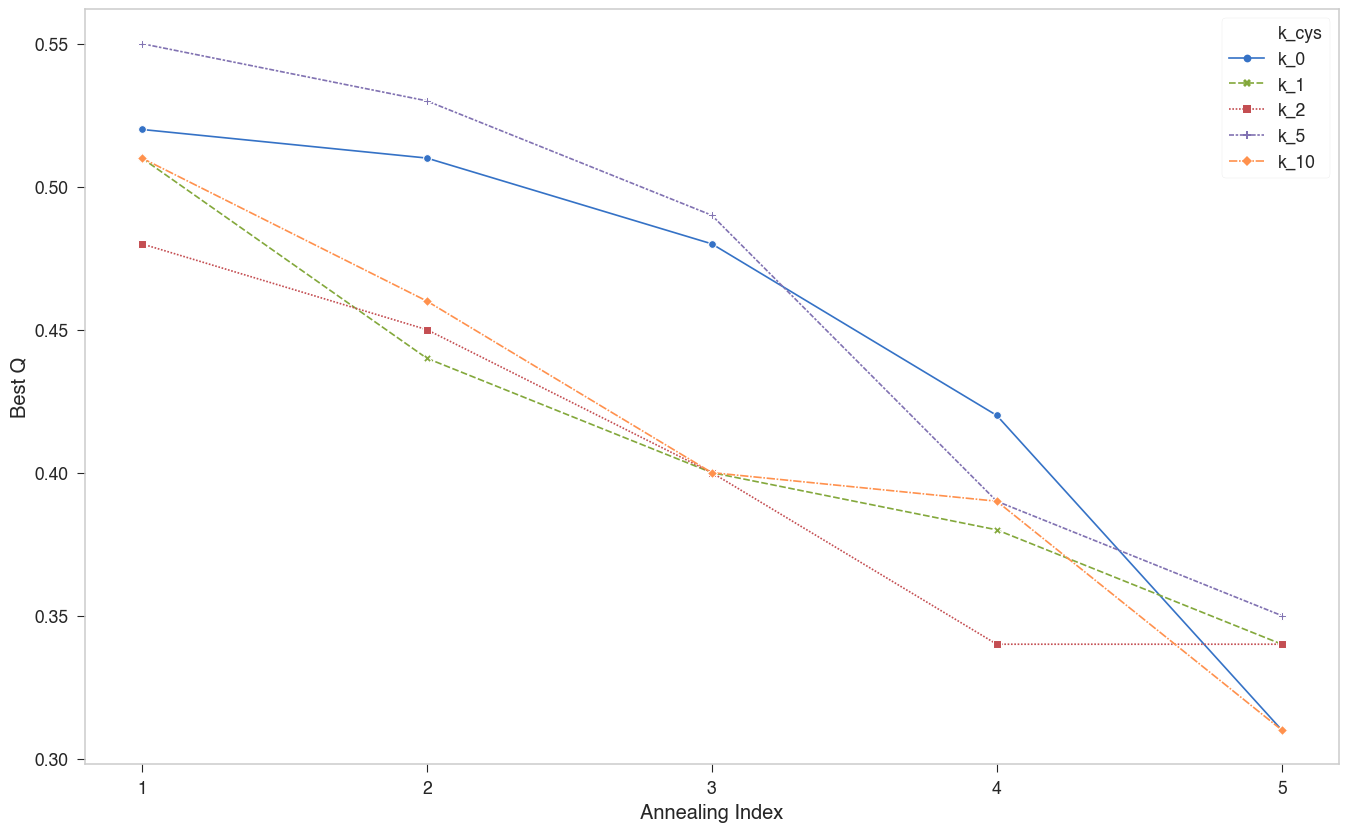

In [34]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
# Q_max["Annealing Index"] = list(range(20, 0, -1))*4
n_run = 5
Q_max["Annealing Index"] = list(range(n_run, 0, -1))*len(subMode_list)

# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max.query("memory == 'ha_mem'").query("k_cys != 'k_50' and k_cys != 'k_20'"), hue="k_cys")
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, n_run+1, 1))

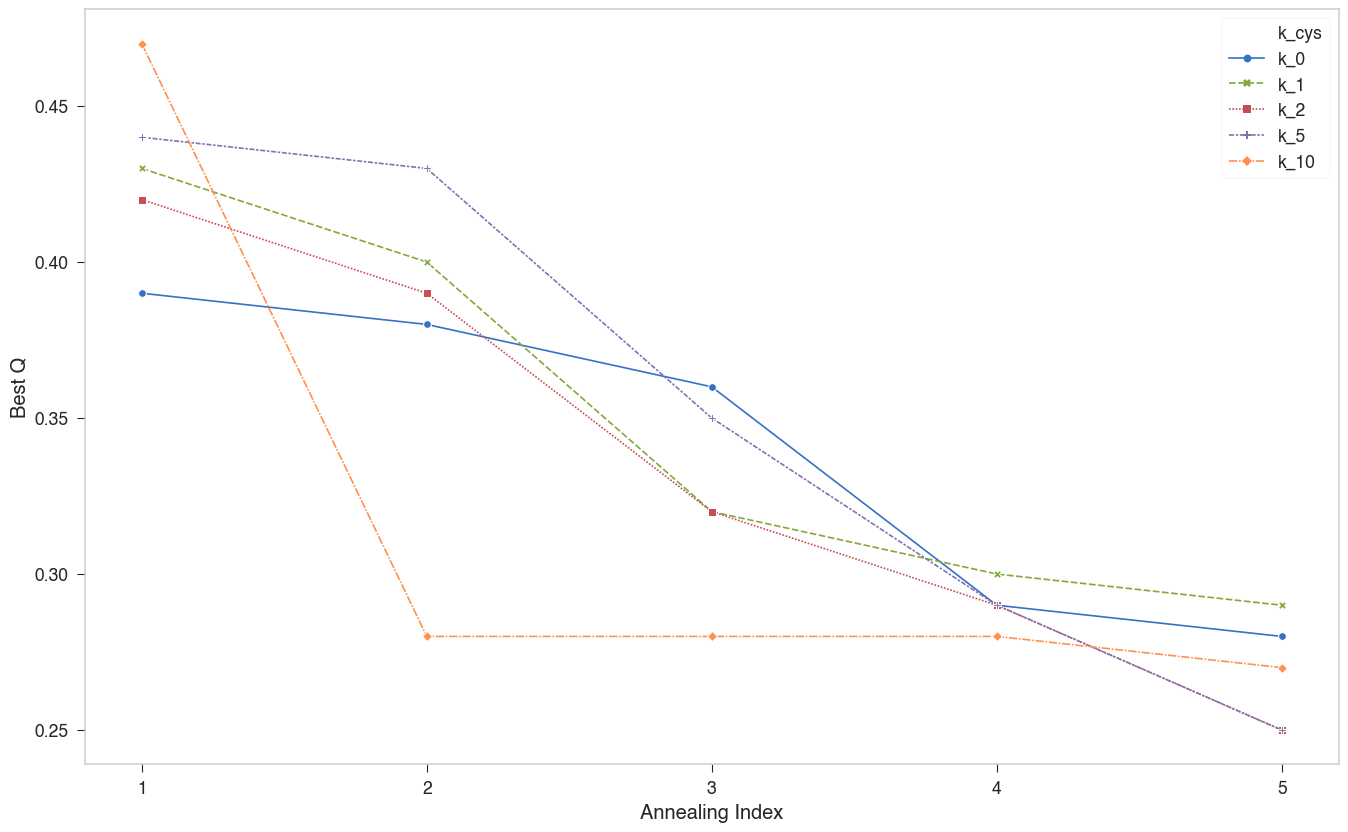

In [33]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
# Q_max["Annealing Index"] = list(range(20, 0, -1))*4
n_run = 5
Q_max["Annealing Index"] = list(range(n_run, 0, -1))*len(subMode_list)

# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max.query("memory == 'frag_mem'").query("k_cys != 'k_50' and k_cys != 'k_20'"), hue="k_cys")
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, n_run+1, 1))

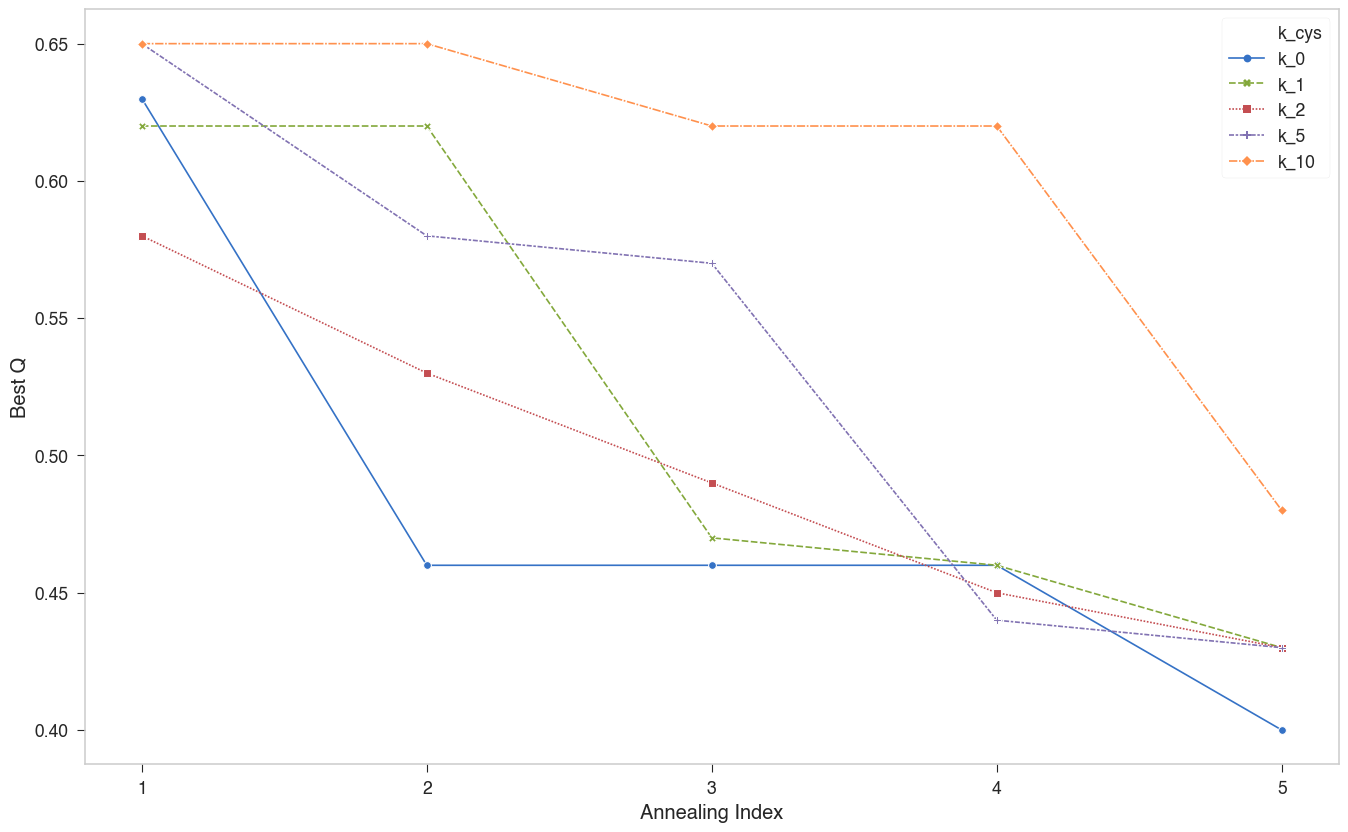

In [31]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
# Q_max["Annealing Index"] = list(range(20, 0, -1))*4
n_run = 5
Q_max["Annealing Index"] = list(range(n_run, 0, -1))*len(subMode_list)

# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max.query("memory == 'single_mem'").query("k_cys != 'k_50' and k_cys != 'k_20'"), hue="k_cys")
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, n_run+1, 1))

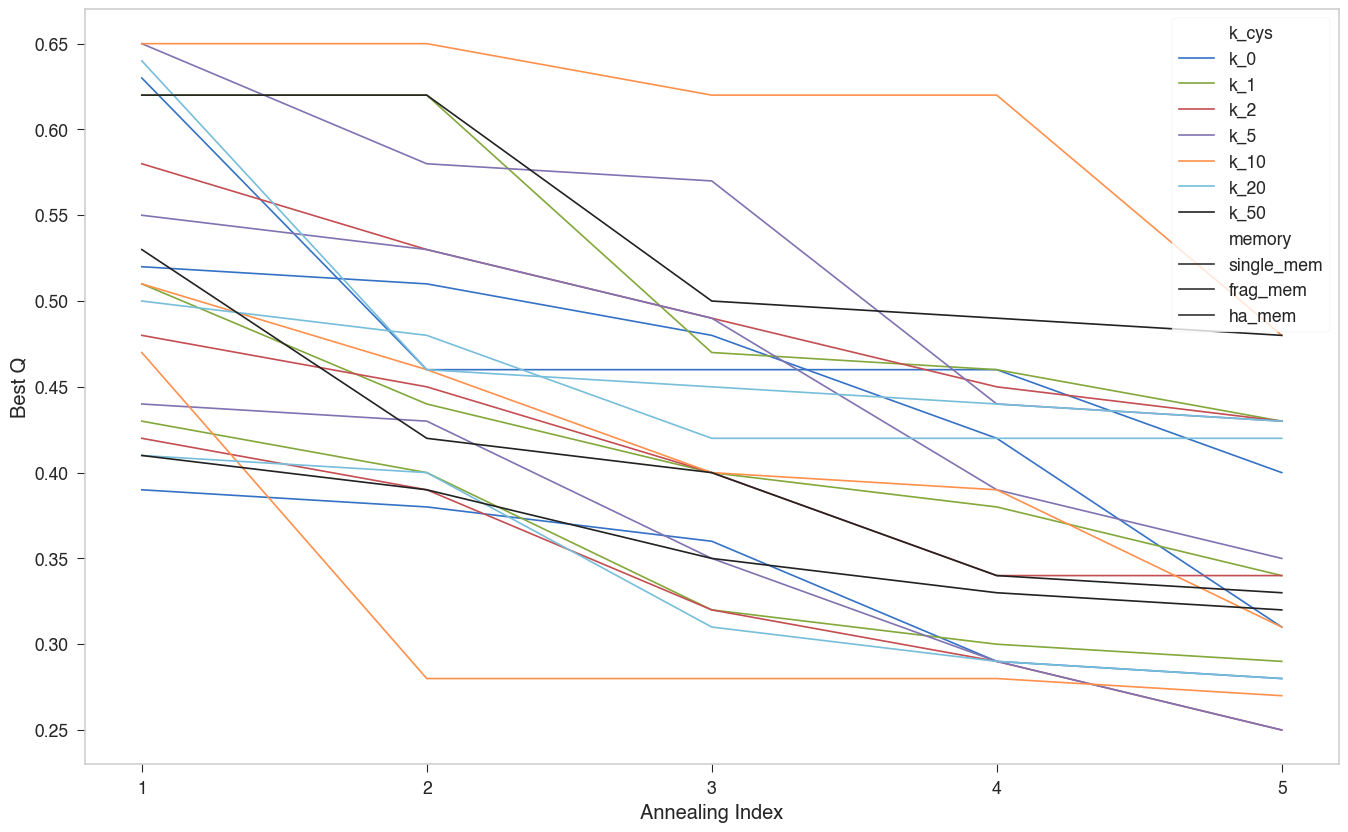

In [21]:
Q_max = data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
# Q_max["Annealing Index"] = list(range(20, 0, -1))*4
n_run = 5
Q_max["Annealing Index"] = list(range(n_run, 0, -1))*len(subMode_list)

# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", style="memory", data=Q_max, hue="k_cys", dashes=False)
plt.ylabel("Best Q")
_ = plt.xticks(np.arange(1, n_run+1, 1))

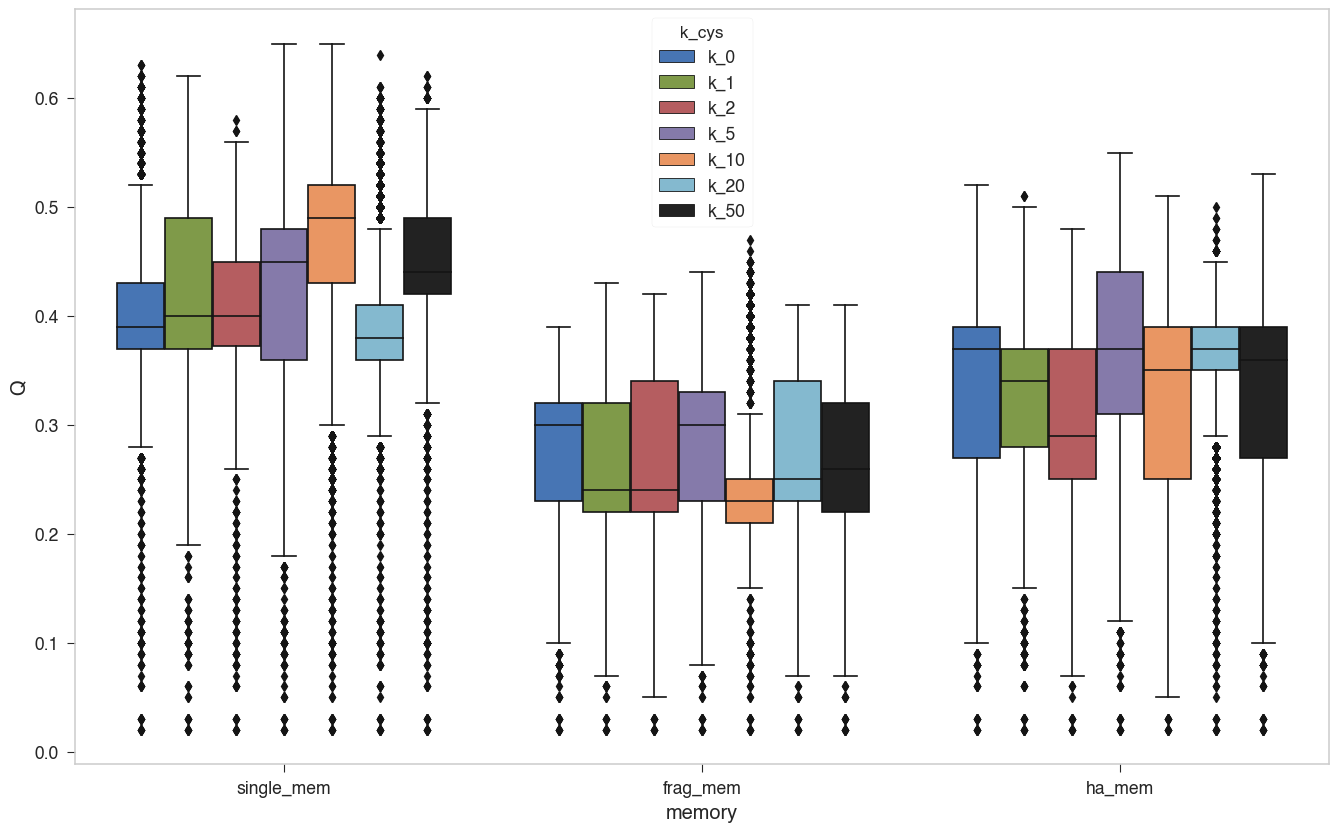

In [13]:
sns.boxplot("memory", "Q", hue="k_cys", data=data)

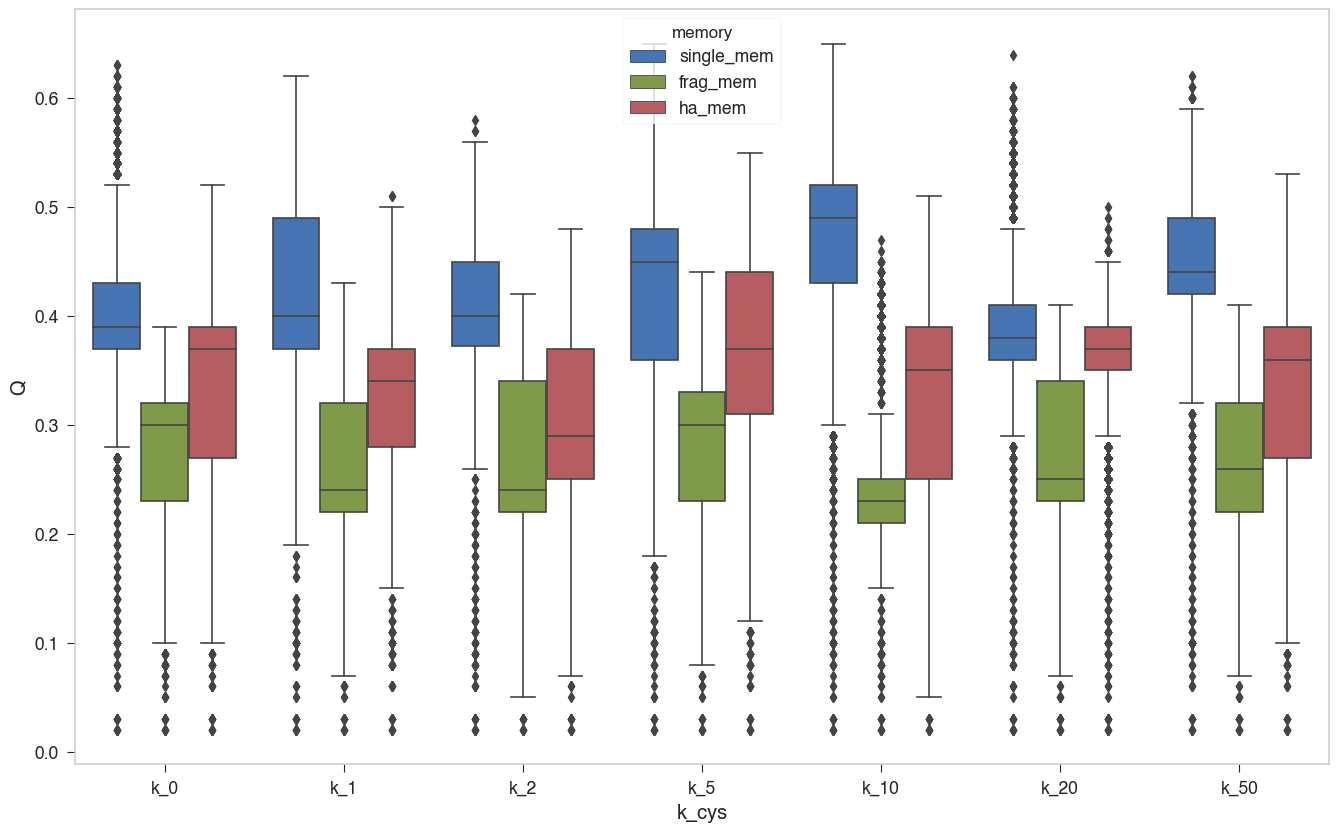

In [12]:
sns.boxplot("k_cys", "Q", hue="memory", data=data)

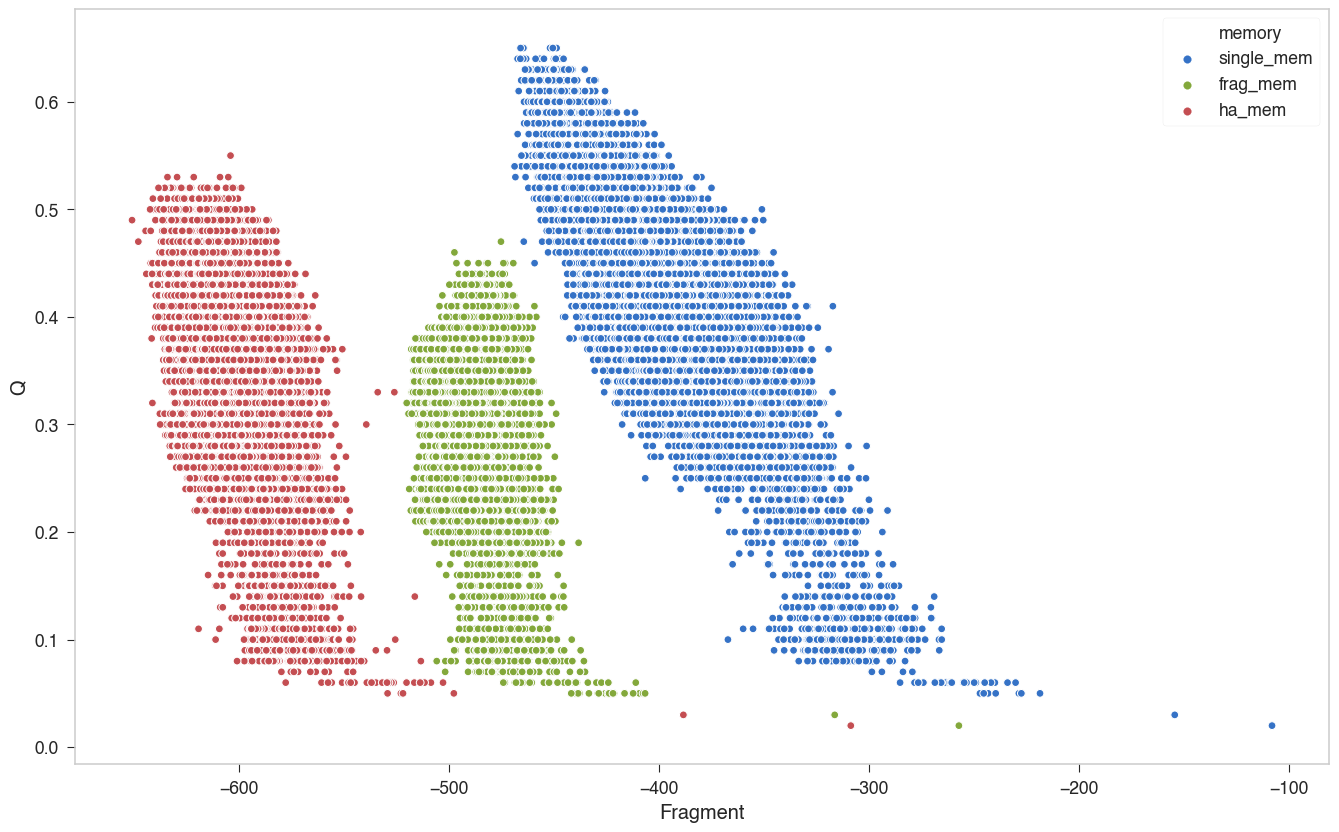

In [11]:
sns.scatterplot("Fragment", "Q", data=data, hue="memory")

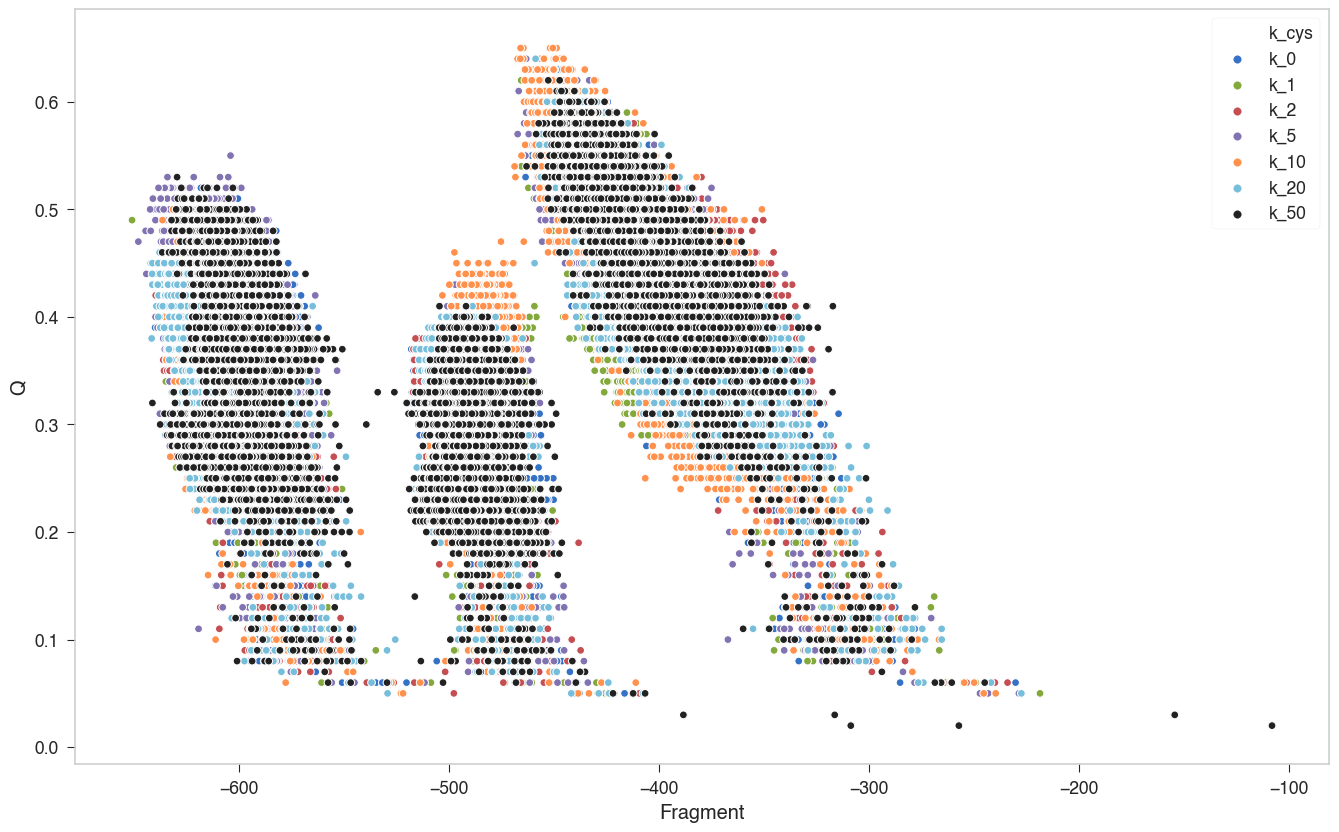

In [10]:
sns.scatterplot("Fragment", "Q", data=data, hue="k_cys")

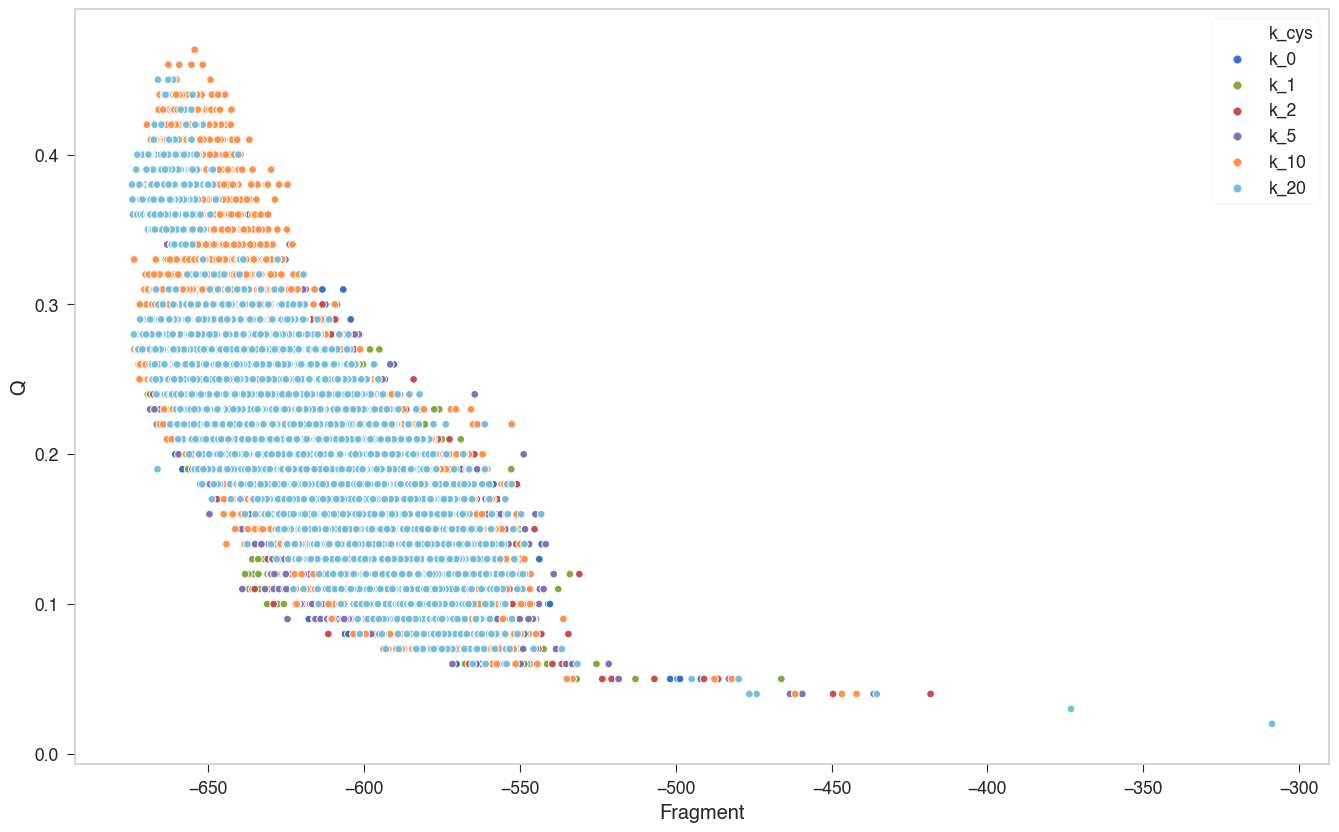

In [30]:
sns.scatterplot("Fragment", "Q", data=data, hue="k_cys")

In [25]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/1fs3_11-18.csv", index_col=0)
data.Submode = data.Submode.astype(str)
submode_list = {"0":"k_0", "1":"k_1", "2":"k_2", "3":"k_5", "4":"k_10", "5":"k_20",
               "10":"k_0", "11":"k_1", "12":"k_2", "13":"k_5", "14":"k_10", "15":"k_20",
               "20":"k_0", "21":"k_1", "22":"k_2", "23":"k_5", "24":"k_10", "25":"k_20",}
submode_mem_list = {"0":"single_mem", "1":"single_mem", "2":"single_mem", "3":"single_mem", "4":"single_mem", "5":"single_mem",
               "10":"frag_mem", "11":"frag_mem", "12":"frag_mem", "13":"frag_mem", "14":"frag_mem", "15":"frag_mem",
                   "20":"ha_mem", "21":"ha_mem", "22":"ha_mem", "23":"ha_mem", "24":"ha_mem", "25":"ha_mem"}

data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])

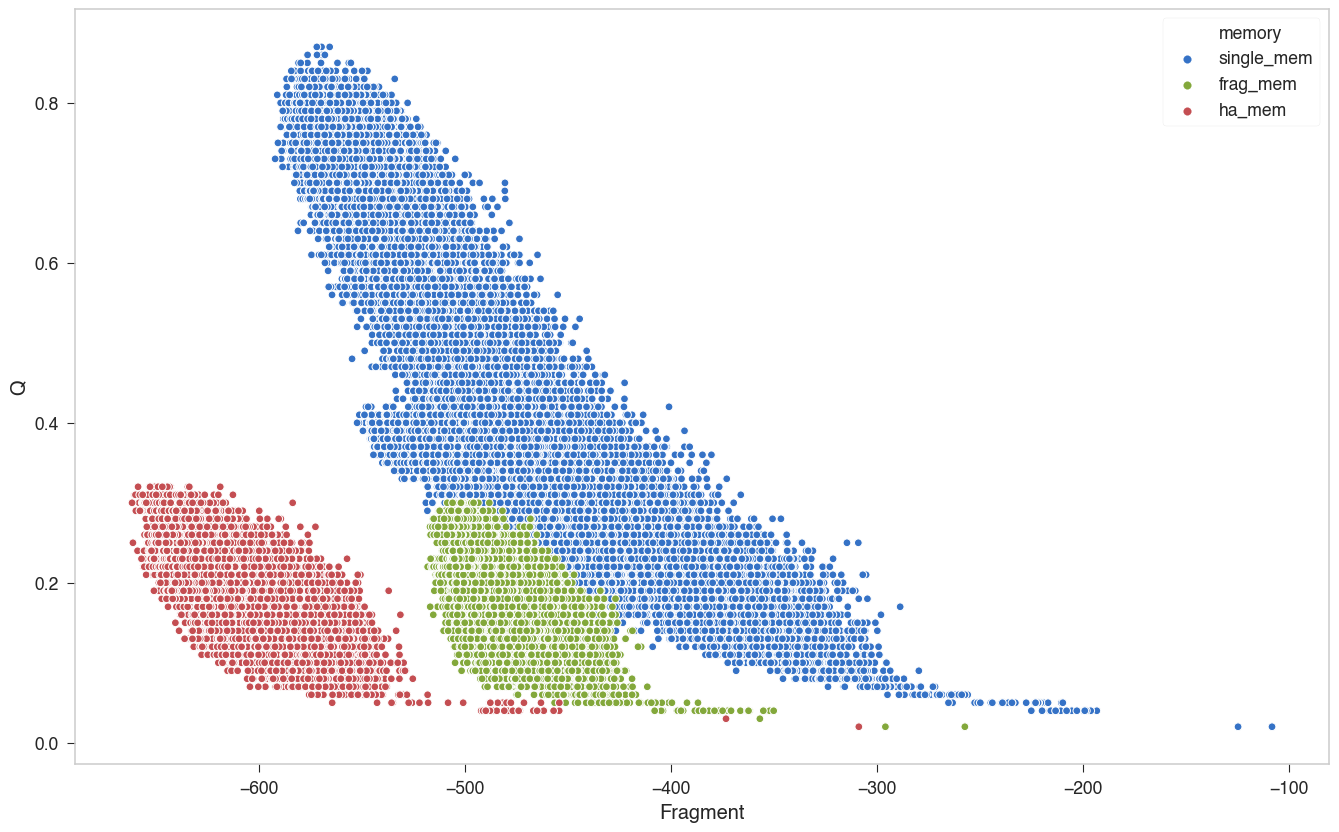

In [26]:
sns.scatterplot("Fragment", "Q", data=data, hue="memory")

In [3]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/cys_proteins_08-15.csv",index_col=0)

In [5]:
data["Folder"].unique()

array(['eighth_cys', 'eighth_no_cys'], dtype=object)

In [ ]:
convert_dic = {"eighth_cys":"DMP_contact_frag_memory_cys", "eighth_no_cys":"DMP_contact_frag_memory_no_cys",
              "eighth_2_cys":"RaptorX_contact_frag_memory_cys", "eighth_2_no_cys":"RaptorX_contact_frag_memory_no_cys"}
Q_max["Scheme"] = Q_max["Folder"].apply(lambda x: convert_dic[x])

In [32]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/cys_proteins_08-16.csv",index_col=0)

In [33]:
data["Folder"].unique()

array(['eighth_cys', 'eighth_no_cys', 'eighth_2_cys', 'eighth_2_no_cys',
       'one_cys', 'one_no_cys', 'ninth_cys', 'ninth_no_cys'], dtype=object)

In [34]:
# # one is new ha, no er
# # two is homo frag, no er
# three homo frag, raptor er
# # eight_2 is with er, and ha, raptor er
# eight is with er, and ha
# # ninth without er

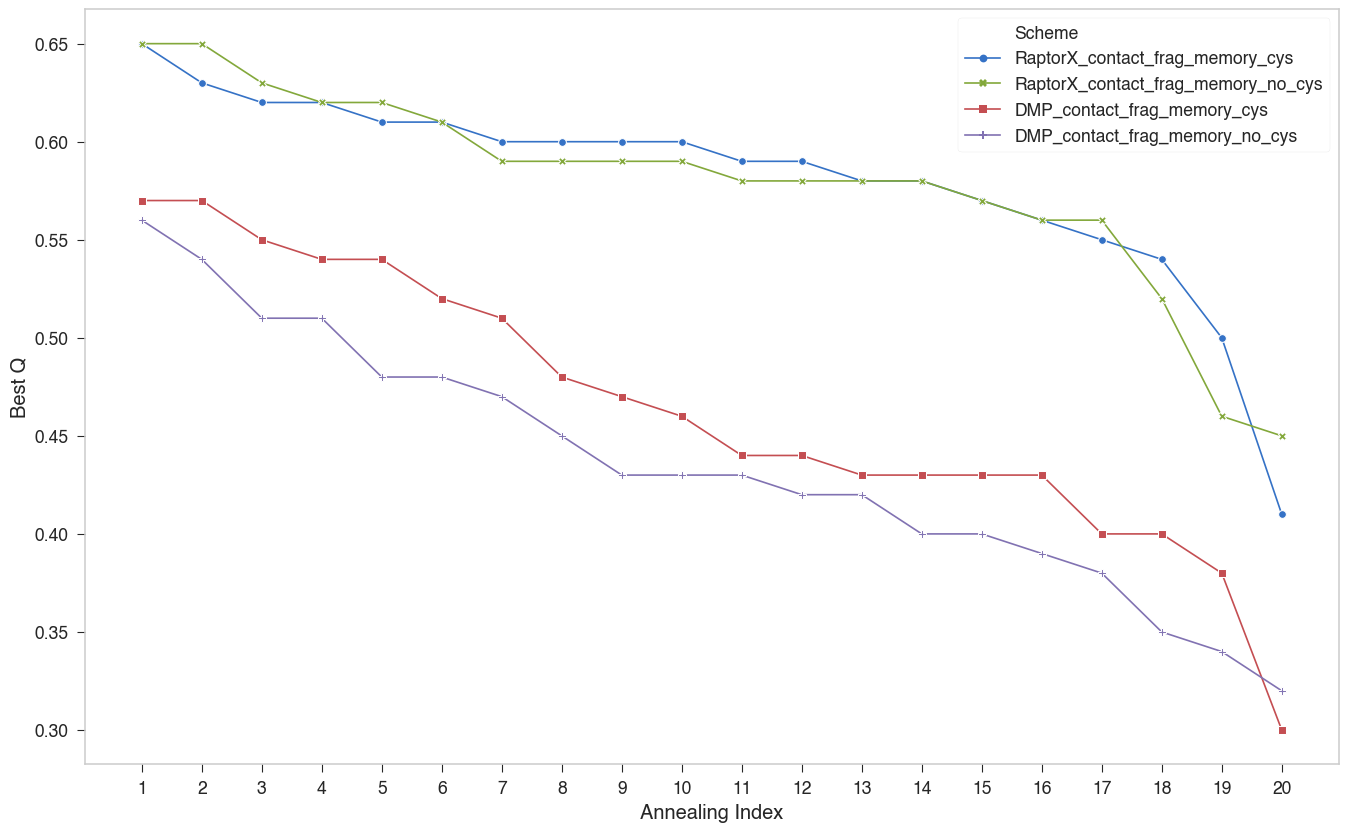

In [36]:
last = data.query("Steps > 350 and Folder in ['eighth_2_cys', 'eighth_2_no_cys', 'eighth_cys', 'eighth_no_cys']")
Q_max = last.sort_values('Q').groupby(["Folder", "Run"]).tail(1).sort_values(['Folder', "Q"])
Q_max["Annealing Index"] = list(range(20, 0, -1))*4

convert_dic = {"eighth_cys":"DMP_contact_frag_memory_cys", "eighth_no_cys":"DMP_contact_frag_memory_no_cys",
              "eighth_2_cys":"RaptorX_contact_frag_memory_cys", "eighth_2_no_cys":"RaptorX_contact_frag_memory_no_cys"}
Q_max["Scheme"] = Q_max["Folder"].apply(lambda x: convert_dic[x])

# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

sns.lineplot("Annealing Index", "Q", hue="Scheme", markers=True, data=Q_max, style="Scheme", dashes=False)
from  matplotlib.ticker import FuncFormatter
# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
_ = plt.xticks(np.arange(1, 20+1, 1))
plt.ylabel("Best Q")

plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/cys_frag_with_er.png", dpi=300)

In [11]:
data["Folder"].unique()

array(['second_single_mem_cys_again', 'second_cys', 'second_no_cys'],
      dtype=object)

In [38]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/cys_proteins_08-13.csv",index_col=0)
last = data.query("Steps > 350")
Q_max = last.sort_values('Q').groupby(["Folder", "Run"]).tail(1).sort_values(['Folder', "Q"], ascending=True)
Q_max["Annealing Index"] = list(range(20, 0, -1))*3

Q_max = Q_max.query("Folder != 'second_single_mem_cys_again'")
convert_dic = {"second_cys":"single_memory_with cys", "second_no_cys":"single_memory_witout_cys", "eighth_cys":"DMP_contact_frag_memory_cys", "eighth_no_cys":"DMP_contact_frag_memory_no_cys",
              "eighth_2_cys":"RaptorX_contact_frag_memory_cys", "eighth_2_no_cys":"RaptorX_contact_frag_memory_no_cys"}
Q_max["Scheme"] = Q_max["Folder"].apply(lambda x: convert_dic[x])

In [26]:
# second is single memory

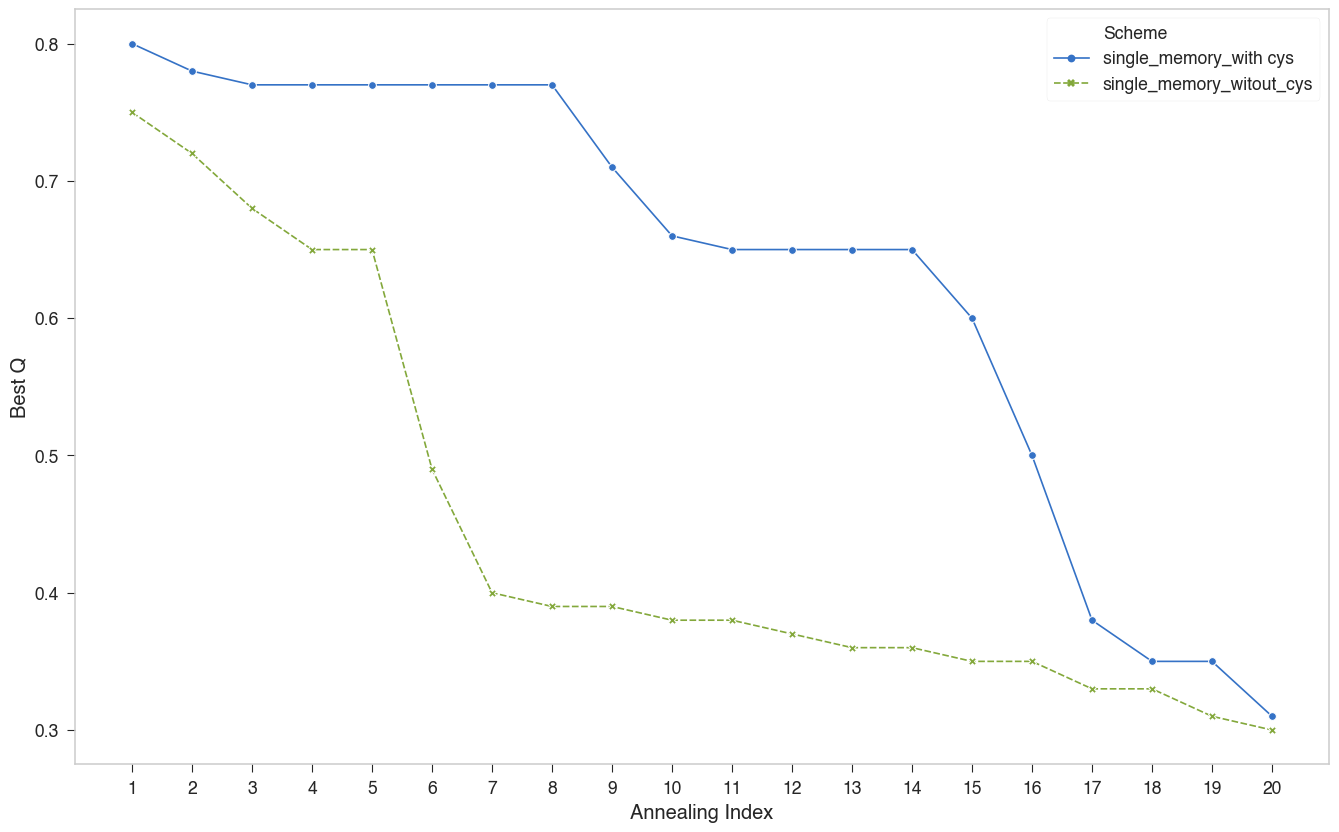

In [39]:
sns.lineplot("Annealing Index", "Q", hue="Scheme", markers=True, data=Q_max, style="Scheme")
from  matplotlib.ticker import FuncFormatter
# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
_ = plt.xticks(np.arange(1, 20+1, 1))
plt.ylabel("Best Q")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/cys_single_without_er.png", dpi=300)

In [ ]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1fs3"]
subMode_list = [0, 1, 2, 3, 4, 5]
subMode_list += [10, 11, 12, 13, 14, 15]
subMode_list += [20, 21, 22, 23, 24, 25]
simulationType = "1fs3"
subFolder = "run_weaker_beta_pap"
pre = "/Users/weilu/Research/server/nov_2019/nov_2019/cys_1fs3/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(5):
            pre = f"/Users/weilu/Research/server/nov_2019/cys_1fs3/{subFolder}/1fs3/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except:
                print(pdb, i, submode, location)
                pass
data = pd.concat(all_data, sort=False)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)
info = pd.DataFrame(info)

In [ ]:
submode_list = {"0":"k_0", "1":"k_1", "2":"k_2", "3":"k_5", "4":"k_10", "5":"k_20",
               "10":"k_0", "11":"k_1", "12":"k_2", "13":"k_5", "14":"k_10", "15":"k_20",
               "20":"k_0", "21":"k_1", "22":"k_2", "23":"k_5", "24":"k_10", "25":"k_20",}
submode_mem_list = {"0":"single_mem", "1":"single_mem", "2":"single_mem", "3":"single_mem", "4":"single_mem", "5":"single_mem",
               "10":"frag_mem", "11":"frag_mem", "12":"frag_mem", "13":"frag_mem", "14":"frag_mem", "15":"frag_mem",
                   "20":"ha_mem", "21":"ha_mem", "22":"ha_mem", "23":"ha_mem", "24":"ha_mem", "25":"ha_mem"}

data["k_cys"] = data.Submode.apply(lambda x:submode_list[x])
data["memory"] = data.Submode.apply(lambda x:submode_mem_list[x])